# Final Project Submission

* Student name: Justin Grisanti
* Student pace: self-paced
* Scheduled project review date/time: 6/20/2022
* Instructor name: Claude Fried
* Blog post URL: https://justingrisanti.github.io/spotify_recommendation_system

# Section 1: Business Understanding

The purpose of this section is to define the business problem and understand the stakeholders for the work that I am performing. Spotify is an audio streaming and media services platfrom, created in 2006. It is one of the largest music streaming service providers with over 406 million monthly active users, including 180 million paying subscribers, as of December 2021.

Spotify offers digital copyright restricted recorded music and podcasts, including more than 82 million songs, from record labels and media companies. As a freemium service, basic features are free with advertisements and limited control, while additional features, such as offline listening and commercial-free listening, are offered via paid subscriptions. Spotify is currently available in 180+ countries as of October 2021. Users can search for music based on artist, album, or genre, and can create, edit, and share playlists.

Two of the most important aspects of Spotify that has led to its popularity are its music discovery functionalities, and playlist creation fostering a new social aspect to music listening. In a 2021 How-To Geek article called "6 Awesome Spotify Features You Should Be Using," 3 of the 6 features are related to playlists, and one speaks about music discovery. One of these features related to music discovery is called "Enhance." Enhance allows you to discover new tracks that might best fit one of your existing playlists. For example, if you have a playlist of a collection of 80s rock songs, Enhance might suggest that you add "Eye of the Tiger" by Survivor. 

What I aim to perform is to create a recommendation system from scratch that can reperform the functionality of Enhance, which is to obtain a selection of songs and use content-based filtering to suggest a list of songs that are similar.

The stakeholders of this project are Spotify, music-listeners, DJs, and other music-related occupations.

The main purpose of this recommendation system is inferential, meaning that this model should be able infer  information about songs from a given playlist and then to predict songs that a user will likely add to that same playlist.

# Section 2: Data Understanding

Now that I have developed a overall business understanding, I will take a deeper dive into the data that I will be using for this project.

In [7]:
# Import relevant libraries

import pandas as pd
from numpy.random import seed
seed(123)
import numpy as np
import random
import shutil
import math
import statistics as stat
import os
import datetime
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity as cos
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import json
from pandas.io.json import json_normalize
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import config
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=config.api_key,
                                                           client_secret=config.api_secret))
import sqlite3 
conn = sqlite3.connect('music_recs.db')
cur = conn.cursor()
from pyspark import SparkContext
from pyspark.sql import SparkSession
import dataframe_image as dfi

import sys
import re
import collections

In [8]:
# Set input path for os functions

input_path = 'spotify_million_playlist_dataset/data/'

In [9]:
# Check how many items are in the data folder. There are 1000 files with 1000 playlists each

list = os.listdir(input_path) 
number_files = len(list)
print(number_files)

1000


In [10]:
# View a handful of files to see their types

os.listdir(input_path)[0:5]

['mpd.slice.549000-549999.json',
 'mpd.slice.613000-613999.json',
 'mpd.slice.115000-115999.json',
 'mpd.slice.778000-778999.json',
 'mpd.slice.290000-290999.json']

As we can see above, it appears that we have 1000 json files in our data folder. Each file appears to have 1000 records each, which means there are 1 million songs in our dataset. After trying to load the first file, it was too large for my computer to handle. Instead, I will load the first playlist to see its contents.

In [11]:
# Open json file to see formatting

test = open(input_path+'mpd.slice.0-999.json')
data_0_999 = json.load(test)
data_0_999['playlists'][0]

{'name': 'Throwbacks',
 'collaborative': 'false',
 'pid': 0,
 'modified_at': 1493424000,
 'num_tracks': 52,
 'num_albums': 47,
 'num_followers': 1,
 'tracks': [{'pos': 0,
   'artist_name': 'Missy Elliott',
   'track_uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
   'artist_uri': 'spotify:artist:2wIVse2owClT7go1WT98tk',
   'track_name': 'Lose Control (feat. Ciara & Fat Man Scoop)',
   'album_uri': 'spotify:album:6vV5UrXcfyQD1wu4Qo2I9K',
   'duration_ms': 226863,
   'album_name': 'The Cookbook'},
  {'pos': 1,
   'artist_name': 'Britney Spears',
   'track_uri': 'spotify:track:6I9VzXrHxO9rA9A5euc8Ak',
   'artist_uri': 'spotify:artist:26dSoYclwsYLMAKD3tpOr4',
   'track_name': 'Toxic',
   'album_uri': 'spotify:album:0z7pVBGOD7HCIB7S8eLkLI',
   'duration_ms': 198800,
   'album_name': 'In The Zone'},
  {'pos': 2,
   'artist_name': 'Beyoncé',
   'track_uri': 'spotify:track:0WqIKmW4BTrj3eJFmnCKMv',
   'artist_uri': 'spotify:artist:6vWDO969PvNqNYHIOW5v0m',
   'track_name': 'Crazy In Love',
   'alb

Looking at this playlist above, we can see that we have the following features:

>**Playlist Attributes**
>* Playlist Name
>* Playlist Type
>* Number of Tracks
>* Number of Unique Albums
>* Number of Followers
>* Number of Edits
>* Duration in Milliseconds
>* Number of Artists
>
>**Song Attributes**
>* Artist Name
>* Track URI
>* Artist URI
>* Track Name
>* Album URI
>* Duration in Milliseconds
>* Album Name

Some features that will be important to our model will be track name, artist name, album name, and their respective URIs. These will help us get more detail about a song from Spotipy. Another piece that could be helpful is the number of followers. This shows us interest in a given playlist. If a playlist has a jumble of random songs that don't form a cohesive playlist, it will probably have less followers than a well-crafted playlist.

Next, I will run code that was provided with the data, to get a better understanding on the population as a whole.

In [12]:
total_playlists = 0
total_tracks = 0
tracks = set()
artists = set()
albums = set()
titles = set()
total_descriptions = 0
ntitles = set()
title_histogram = collections.Counter()
artist_histogram = collections.Counter()
track_histogram = collections.Counter()
last_modified_histogram = collections.Counter()
num_edits_histogram = collections.Counter()
playlist_length_histogram = collections.Counter()
num_followers_histogram = collections.Counter()

quick = False
max_files_for_quick_processing = 5


def process_mpd(path):
    count = 0
    filenames = os.listdir(input_path)
    for filename in sorted(filenames):
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((input_path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            mpd_slice = json.loads(js)
            process_info(mpd_slice["info"])
            for playlist in mpd_slice["playlists"]:
                process_playlist(playlist)
            count += 1

            if quick and count > max_files_for_quick_processing:
                break

    show_summary()


def show_summary():
    print()
    print("number of playlists", total_playlists)
    print("number of tracks", total_tracks)
    print("number of unique tracks", len(tracks))
    print("number of unique albums", len(albums))
    print("number of unique artists", len(artists))
    print("number of unique titles", len(titles))
    print("number of playlists with descriptions", total_descriptions)
    print("number of unique normalized titles", len(ntitles))
    print("avg playlist length", float(total_tracks) / total_playlists)
    print()
    print("top playlist titles")
    for title, count in title_histogram.most_common(20):
        print("%7d %s" % (count, title))

    print()
    print("top tracks")
    for track, count in track_histogram.most_common(20):
        print("%7d %s" % (count, track))

    print()
    print("top artists")
    for artist, count in artist_histogram.most_common(20):
        print("%7d %s" % (count, artist))

    print()
    print("numedits histogram")
    for num_edits, count in num_edits_histogram.most_common(20):
        print("%7d %d" % (count, num_edits))

    print()
    print("last modified histogram")
    for ts, count in last_modified_histogram.most_common(20):
        print("%7d %s" % (count, to_date(ts)))

    print()
    print("playlist length histogram")
    for length, count in playlist_length_histogram.most_common(20):
        print("%7d %d" % (count, length))

    print()
    print("num followers histogram")
    for followers, count in num_followers_histogram.most_common(20):
        print("%7d %d" % (count, followers))


def normalize_name(name):
    name = name.lower()
    name = re.sub(r"[.,\/#!$%\^\*;:{}=\_`~()@]", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name


def to_date(epoch):
    return datetime.datetime.fromtimestamp(epoch).strftime("%Y-%m-%d")


def process_playlist(playlist):
    global total_playlists, total_tracks, total_descriptions

    total_playlists += 1
    # print playlist['playlist_id'], playlist['name']

    if "description" in playlist:
        total_descriptions += 1

    titles.add(playlist["name"])
    nname = normalize_name(playlist["name"])
    ntitles.add(nname)
    title_histogram[nname] += 1

    playlist_length_histogram[playlist["num_tracks"]] += 1
    last_modified_histogram[playlist["modified_at"]] += 1
    num_edits_histogram[playlist["num_edits"]] += 1
    num_followers_histogram[playlist["num_followers"]] += 1

    for track in playlist["tracks"]:
        total_tracks += 1
        albums.add(track["album_uri"])
        tracks.add(track["track_uri"])
        artists.add(track["artist_uri"])

        full_name = track["track_name"] + " by " + track["artist_name"]
        artist_histogram[track["artist_name"]] += 1
        track_histogram[full_name] += 1


def process_info(_):
    pass


if __name__ == "__main__":
    path = sys.argv[1]
    if len(sys.argv) > 2 and sys.argv[2] == "--quick":
        quick = True
    process_mpd(path)



number of playlists 1000000
number of tracks 66346428
number of unique tracks 2262292
number of unique albums 734684
number of unique artists 295860
number of unique titles 92944
number of playlists with descriptions 18760
number of unique normalized titles 17381
avg playlist length 66.346428

top playlist titles
  10000 country
  10000 chill
   8493 rap
   8481 workout
   8146 oldies
   8015 christmas
   6848 rock
   6157 party
   5883 throwback
   5063 jams
   5052 worship
   4907 summer
   4677 feels
   4612 new
   4186 disney
   4124 lit
   4030 throwbacks
   3886 music
   3513 sleep
   3500 vibes

top tracks
  46574 HUMBLE. by Kendrick Lamar
  43447 One Dance by Drake
  41309 Broccoli (feat. Lil Yachty) by DRAM
  41079 Closer by The Chainsmokers
  39987 Congratulations by Post Malone
  35202 Caroline by Aminé
  35138 iSpy (feat. Lil Yachty) by KYLE
  34999 Bad and Boujee (feat. Lil Uzi Vert) by Migos
  34990 Location by Khalid
  34922 XO TOUR Llif3 by Lil Uzi Vert
  33699 Bounce 

As we see in the summary above, there are 1 million playlists with over 66 million songs. Within these playlists, there are 2.2 million unique songs, 734k unique albums, and 300k unique artists. There is a lot of data to work with here. The playlists are sorted into categories, with country and chill being the top, followed by rap and workout. Drake, Kanye West, and Kendrick Lamar are the 3 top artists. The next step in this process is to convert all of this json data to be compatible with python. 

# Section 3: Data Preparation



The first steps are to convert our JSON data to python and DataFrames. Once we have that, we need to unwrap our track data so it can be converted to a DataFrame, as well.

In [13]:
# This code was used to open 100 of the files in the dataset and append them to one dataframe.
# We then select the top 100 playlists according to number of followers, as we assume these are the most 
# cohesive playlists

## Start time to measure code execution length of time
# start_time = time.time()

## Generate DataFrame for playlist data
# spotify_playlist_data = pd.DataFrame()

## For Loop to open and append 100 json files to a DataFrame
# for item in range(0,100):
#     open_file = open(input_path+sorted(os.listdir(input_path))[item])
#     load_file = json.load(open_file)
#     spotify_playlist_data = spotify_playlist_data.append(load_file['playlists'],ignore_index=True)

## Send our DataFrame to a pickle file so we can call it instead of running this code every time
# spotify_playlist_data.to_pickle('Spotipy Custom DataFrames/spotify_playlist_data.pkl')

## Creating a top 100 playlist DataFrame to select the top 100 most followed playlist from our selection
# spotify_playlist_top_100 = spotify_playlist_data.sort_values(by='num_followers',ascending=False).head(100)
# spotify_playlist_top_100 = spotify_playlist_top_100.set_index('pid')
# spotify_playlist_top_100.to_pickle('Spotipy Custom DataFrames/spotify_playlist_top_100.pkl')

# print("--- %s minutes ---" % ((time.time() - start_time)/60))

# Output: --- 0.7003742297490437 minutes ---

In [14]:
# Open pickle file with our top 100 playlist DataFrame
spd_top100 = pd.read_pickle('Spotipy Custom DataFrames/spotify_playlist_top_100.pkl')
spd_top100

,name,collaborative,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
pid,,,,,,,,,,,
180831,My Little Pony,false,1478908800,85,9,31539,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",6,11824924,25,NaN
159077,Rock Hits,false,1509408000,56,54,22102,"[{'pos': 0, 'artist_name': 'Foo Fighters', 'tr...",6,12528923,54,NaN
101121,Workout Playlist,false,1456531200,26,23,11745,"[{'pos': 0, 'artist_name': 'Becky G', 'track_u...",8,5900266,19,NaN
147486,J cole,false,1491523200,139,55,7912,"[{'pos': 0, 'artist_name': 'J. Cole', 'track_u...",25,34552447,36,NaN
17675,raggaeton,false,1501718400,107,71,2994,"[{'pos': 0, 'artist_name': 'R.K.M & Ken-Y', 't...",22,24727853,36,NaN
...,...,...,...,...,...,...,...,...,...,...,...
100819,Dance!,false,1440115200,10,6,74,"[{'pos': 0, 'artist_name': 'Arturo Márquez', '...",2,4495392,8,"From my catalogue, tracks to dance to!"
127212,Demi Lovato,false,1470009600,84,23,72,"[{'pos': 0, 'artist_name': 'Demi Lovato', 'tra...",16,17788383,10,NaN
154640,Thankful.,false,1479168000,63,62,72,"[{'pos': 0, 'artist_name': 'tobyMac', 'track_u...",3,16129895,57,Your soundtrack for Thanksgiving features 4 1/...


Now that we have aggregated our data, we can see that our track data is nested, which makes sense given we are using json data. In order to get this track data into a pandas dataframe, we will be using similar code to normalize our track data into its own dataframe. We will also pull in the playlist id so we know which track relates to which playlist for when we analyze or use SQL. 

In [15]:
# pd.set_option('display.max_rows', 20)

## Creating DataFrame for the tracks column in our playlist data. It is formatted like a json file, so I will convert to DataFrame
# unwrapped_track_data = pd.DataFrame()

## Adding playlist IDs to a list to be appended to the unwrapped track data
# index_list = spd_top100.index.tolist()
# pid = []

## Using json_normalize to reformat the json data the DataFrame
# for item in range(0,len(spd_top100)):
#     unwrapped_track_data = unwrapped_track_data.append(pd.json_normalize(data=spd_top100['tracks'].iloc[item]),ignore_index=True)

## Appending the playlist IDs to the pid list
# for row in range(0,len(spd_top100.index)):
#     track=0
#     while track<spd_top100['num_tracks'].iloc[row]:
#         track+=1
#         pid.append(index_list[row])

## Adding the playlist IDs to the unwrapped track data
# unwrapped_track_data['pid'] = pid

## Save the data as a pickle file
# unwrapped_track_data.to_pickle('Spotipy Custom DataFrames/unwrapped_track_data.pkl')

In [16]:
# Call the pickle file for data use
unwrapped_track_data = pd.read_pickle('Spotipy Custom DataFrames/unwrapped_track_data.pkl')
unwrapped_track_data

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid
0,0,Applebloom,spotify:track:527IbJxFcjjTix0ONdxDdS,spotify:artist:7ggsXdK95oJBkuZu1txVjC,Hearts as Strong as Horses,spotify:album:6u81maqYRkf7SmHeeq2oHA,123569,Songs of Ponyville (Music from the Original TV...,180831
1,1,Apple Jack,spotify:track:1mOnMHXxt2vGI0b804eQsy,spotify:artist:1r0v3fdCiqrr9mYtvbCccT,Apples to the Core,spotify:album:6u81maqYRkf7SmHeeq2oHA,125833,Songs of Ponyville (Music from the Original TV...,180831
2,2,Twilight Sparkle,spotify:track:4GciJR91Tj8a7dLJ12WFvr,spotify:artist:53CQUfjaBNRwV2nFro1nac,Ballad of the Crystal Ponies,spotify:album:6u81maqYRkf7SmHeeq2oHA,99304,Songs of Ponyville (Music from the Original TV...,180831
3,3,Twilight Sparkle,spotify:track:68dC0K4xglMF5Nhr44TevS,spotify:artist:53CQUfjaBNRwV2nFro1nac,Find a Way,spotify:album:6u81maqYRkf7SmHeeq2oHA,100473,Songs of Ponyville (Music from the Original TV...,180831
4,4,Twilight Sparkle,spotify:track:0vhKFkvwgdPBrrNr9gUbVa,spotify:artist:53CQUfjaBNRwV2nFro1nac,"A True, True Friend",spotify:album:6u81maqYRkf7SmHeeq2oHA,211840,Songs of Ponyville (Music from the Original TV...,180831
...,...,...,...,...,...,...,...,...,...
9318,66,Fake ID,spotify:track:3G0PWfSGIsUrI4El8u46EX,spotify:artist:4GwCpkFWajqx3KSm0MVh2a,All Or Nothing,spotify:album:7LfKQOyYrhtCEqR4rr2J2M,200066,Punk Goes Pop,147046
9319,67,Showoff,spotify:track:5qpQhP4hyjCKC95oRtTqni,spotify:artist:6IKhTkyp4EJ0ocidcwafs6,Borderline,spotify:album:7LfKQOyYrhtCEqR4rr2J2M,218933,Punk Goes Pop,147046
9320,68,Thrice,spotify:track:7wwXG5FOebfhVBotX4vTXo,spotify:artist:3NChzMpu9exTlNPiqUQ2DE,Send Me An Angel,spotify:album:7LfKQOyYrhtCEqR4rr2J2M,204200,Punk Goes Pop,147046
9321,69,Nicotine,spotify:track:1Ibfp4HOrAS0fB8eIoEYko,spotify:artist:0p3U0uLx2oSf0yn8i5XZki,Baby One More Time,spotify:album:7LfKQOyYrhtCEqR4rr2J2M,153400,Punk Goes Pop,147046


In [17]:
# Ensure the sum of the number of tracks for each playlist equals the number of rows for the unwrapped tracks
spd_top100['num_tracks'].sum() == unwrapped_track_data.shape[0]

True

In [18]:
# Stripping the URI fields to leave only the URI itself
unwrapped_track_data['track_uri'] = unwrapped_track_data['track_uri'].map(lambda x: x.lstrip('spotify:track:'))
unwrapped_track_data['artist_uri'] = unwrapped_track_data['artist_uri'].map(lambda x: x.lstrip('spotify:artist:'))
unwrapped_track_data['album_uri'] = unwrapped_track_data['album_uri'].map(lambda x: x.lstrip('spotify:album:'))

In [19]:
unwrapped_track_data

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid
0,0,Applebloom,527IbJxFcjjTix0ONdxDdS,7ggsXdK95oJBkuZu1txVjC,Hearts as Strong as Horses,6u81maqYRkf7SmHeeq2oHA,123569,Songs of Ponyville (Music from the Original TV...,180831
1,1,Apple Jack,1mOnMHXxt2vGI0b804eQsy,1r0v3fdCiqrr9mYtvbCccT,Apples to the Core,6u81maqYRkf7SmHeeq2oHA,125833,Songs of Ponyville (Music from the Original TV...,180831
2,2,Twilight Sparkle,4GciJR91Tj8a7dLJ12WFvr,53CQUfjaBNRwV2nFro1nac,Ballad of the Crystal Ponies,6u81maqYRkf7SmHeeq2oHA,99304,Songs of Ponyville (Music from the Original TV...,180831
3,3,Twilight Sparkle,68dC0K4xglMF5Nhr44TevS,53CQUfjaBNRwV2nFro1nac,Find a Way,6u81maqYRkf7SmHeeq2oHA,100473,Songs of Ponyville (Music from the Original TV...,180831
4,4,Twilight Sparkle,0vhKFkvwgdPBrrNr9gUbVa,53CQUfjaBNRwV2nFro1nac,"A True, True Friend",6u81maqYRkf7SmHeeq2oHA,211840,Songs of Ponyville (Music from the Original TV...,180831
...,...,...,...,...,...,...,...,...,...
9318,66,Fake ID,3G0PWfSGIsUrI4El8u46EX,4GwCpkFWajqx3KSm0MVh2a,All Or Nothing,7LfKQOyYrhtCEqR4rr2J2M,200066,Punk Goes Pop,147046
9319,67,Showoff,5qpQhP4hyjCKC95oRtTqni,6IKhTkyp4EJ0ocidcwafs6,Borderline,7LfKQOyYrhtCEqR4rr2J2M,218933,Punk Goes Pop,147046
9320,68,Thrice,7wwXG5FOebfhVBotX4vTXo,3NChzMpu9exTlNPiqUQ2DE,Send Me An Angel,7LfKQOyYrhtCEqR4rr2J2M,204200,Punk Goes Pop,147046
9321,69,Nicotine,1Ibfp4HOrAS0fB8eIoEYko,0p3U0uLx2oSf0yn8i5XZki,Baby One More Time,7LfKQOyYrhtCEqR4rr2J2M,153400,Punk Goes Pop,147046


Now that our track data is unwrapped, we will remove duplicates to get a DataFrame of unique songs.

In [20]:
# Drop duplicates, reset index, and isolate important columns.
unique_track_data = unwrapped_track_data.drop_duplicates(subset='track_uri')
unique_track_data = unique_track_data.reset_index()
unique_track_data = unique_track_data[['track_uri','track_name','artist_name','artist_uri','album_name','pid']]
unique_track_data.to_sql('unique_track_data', con = conn, if_exists='replace')
unique_track_data

,track_uri,track_name,artist_name,artist_uri,album_name,pid
0,527IbJxFcjjTix0ONdxDdS,Hearts as Strong as Horses,Applebloom,7ggsXdK95oJBkuZu1txVjC,Songs of Ponyville (Music from the Original TV...,180831
1,1mOnMHXxt2vGI0b804eQsy,Apples to the Core,Apple Jack,1r0v3fdCiqrr9mYtvbCccT,Songs of Ponyville (Music from the Original TV...,180831
2,4GciJR91Tj8a7dLJ12WFvr,Ballad of the Crystal Ponies,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,180831
3,68dC0K4xglMF5Nhr44TevS,Find a Way,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,180831
4,0vhKFkvwgdPBrrNr9gUbVa,"A True, True Friend",Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,180831
...,...,...,...,...,...,...
8076,3G0PWfSGIsUrI4El8u46EX,All Or Nothing,Fake ID,4GwCpkFWajqx3KSm0MVh2a,Punk Goes Pop,147046
8077,5qpQhP4hyjCKC95oRtTqni,Borderline,Showoff,6IKhTkyp4EJ0ocidcwafs6,Punk Goes Pop,147046
8078,7wwXG5FOebfhVBotX4vTXo,Send Me An Angel,Thrice,3NChzMpu9exTlNPiqUQ2DE,Punk Goes Pop,147046
8079,1Ibfp4HOrAS0fB8eIoEYko,Baby One More Time,Nicotine,0p3U0uLx2oSf0yn8i5XZki,Punk Goes Pop,147046


Now that I have my data prepared into tables, we will need to import some relevant features that describe the type of each song. While we have already have many features that describe the music, such as song name, length and artist, none of these describe the *charactaristics* of each song. To do this, I have imported the Spotipy library. Per Spotipy's website, this library is described as "a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform." 

We can use this library to get more information about each song, and therefore classify the type of playlist that we are listening to. The reason we have to do this is because the playlist names might not always have a good description of the type of playlist we have. For example, playlist 159077 above is labelled "Rock Hits!", but playlist 154640 is just labelled an arbitrary title, "Thankful.". We can name Rock songs, but "Thankful" songs can be more subjective, and it is harder to classify a sound or vibe from the title alone. Once we have the type of playlist that we are looking at, we can begin suggesting songs from a similar genre or "vibe". 

We will be using the API to import thhe following: 
1. Audio features that analyze the sound/vibe of the song
2. Genre for each song
3. Popularity of each song

## 3.1 Audio Features DataFrames

In [21]:
# Using the audio_features method to get charactaristics of our songs
sp.audio_features('0UaMYEvWZi0ZqiDOoHU3YI')

[{'danceability': 0.904,
  'energy': 0.813,
  'key': 4,
  'loudness': -7.105,
  'mode': 0,
  'speechiness': 0.121,
  'acousticness': 0.0311,
  'instrumentalness': 0.00697,
  'liveness': 0.0471,
  'valence': 0.81,
  'tempo': 125.461,
  'type': 'audio_features',
  'id': '0UaMYEvWZi0ZqiDOoHU3YI',
  'uri': 'spotify:track:0UaMYEvWZi0ZqiDOoHU3YI',
  'track_href': 'https://api.spotify.com/v1/tracks/0UaMYEvWZi0ZqiDOoHU3YI',
  'analysis_url': 'https://api.spotify.com/v1/audio-analysis/0UaMYEvWZi0ZqiDOoHU3YI',
  'duration_ms': 226864,
  'time_signature': 4}]

Above, Spotipy gives us relevant audio features for each song:

> * **Danceability**: describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
>* **Acousticness**: A measure from 0.0 to 1.0 of whether the track is acoustic.
>* **Energy**: a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy.
>* **Instrumentalness**: Predicts whether a track contains no vocals. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content.
>* **Liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live.
>* **Loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track. Values typical range between -60 and 0 db.
>* **Speechiness**: detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value.
>* **Tempo**: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration.
>* **Valence**: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry).

In [22]:
## Creating a DataFrame for all unique tracks and their audio features. I exported this code to a pickle
## file to save time. I also found I was getting rate limited from the Spotify API if I ran it too many times

# audio_features_df = pd.DataFrame()
# start_time = time.time()
# batch_record = 0

## For loop to append audio features for each track
# for track in range(0,len(unique_track_data)):
#     audio_features_df = audio_features_df.append(sp.audio_features(unique_track_data['track_uri'][track]),ignore_index=True) 
#     batch_record +=1
#     if batch_record < 100:
#         pass
#     else:
#         time.sleep(2)
#         batch_record = 0

## Save to pickle to save loading time
# audio_features_df.to_pickle('Spotipy Custom DataFrames/audio_features_df.pkl')

# print("--- %s minutes ---" % ((time.time() - start_time)/60))

# Output time: --- 13.943817913532257 minutes ---

In [23]:
## Call file from pickle
audio_features_df = pd.read_pickle('Spotipy Custom DataFrames/audio_features_df.pkl')
audio_features_df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.794,0.826,1,-4.384,1,0.0294,0.242000,0.000008,0.3130,0.889,124.099,audio_features,527IbJxFcjjTix0ONdxDdS,spotify:track:527IbJxFcjjTix0ONdxDdS,https://api.spotify.com/v1/tracks/527IbJxFcjjT...,https://api.spotify.com/v1/audio-analysis/527I...,123569,4
1,0.802,0.814,0,-2.489,1,0.0286,0.232000,0.000000,0.1700,0.963,120.084,audio_features,1mOnMHXxt2vGI0b804eQsy,spotify:track:1mOnMHXxt2vGI0b804eQsy,https://api.spotify.com/v1/tracks/1mOnMHXxt2vG...,https://api.spotify.com/v1/audio-analysis/1mOn...,125834,4
2,0.632,0.482,0,-7.480,1,0.0289,0.419000,0.000000,0.1350,0.570,111.976,audio_features,4GciJR91Tj8a7dLJ12WFvr,spotify:track:4GciJR91Tj8a7dLJ12WFvr,https://api.spotify.com/v1/tracks/4GciJR91Tj8a...,https://api.spotify.com/v1/audio-analysis/4Gci...,99304,4
3,0.530,0.392,10,-8.648,1,0.0341,0.881000,0.000000,0.1010,0.156,119.871,audio_features,68dC0K4xglMF5Nhr44TevS,spotify:track:68dC0K4xglMF5Nhr44TevS,https://api.spotify.com/v1/tracks/68dC0K4xglMF...,https://api.spotify.com/v1/audio-analysis/68dC...,100474,4
4,0.678,0.735,10,-6.135,1,0.0355,0.305000,0.000000,0.1970,0.603,119.953,audio_features,0vhKFkvwgdPBrrNr9gUbVa,spotify:track:0vhKFkvwgdPBrrNr9gUbVa,https://api.spotify.com/v1/tracks/0vhKFkvwgdPB...,https://api.spotify.com/v1/audio-analysis/0vhK...,211841,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,0.360,0.909,0,-4.105,1,0.0587,0.017700,0.000000,0.0888,0.556,99.746,audio_features,3G0PWfSGIsUrI4El8u46EX,spotify:track:3G0PWfSGIsUrI4El8u46EX,https://api.spotify.com/v1/tracks/3G0PWfSGIsUr...,https://api.spotify.com/v1/audio-analysis/3G0P...,200067,4
8077,0.549,0.901,4,-5.309,1,0.0469,0.014000,0.000667,0.1400,0.526,136.882,audio_features,5qpQhP4hyjCKC95oRtTqni,spotify:track:5qpQhP4hyjCKC95oRtTqni,https://api.spotify.com/v1/tracks/5qpQhP4hyjCK...,https://api.spotify.com/v1/audio-analysis/5qpQ...,218933,4
8078,0.262,0.942,6,-3.739,1,0.0520,0.000008,0.056200,0.0948,0.577,157.170,audio_features,7wwXG5FOebfhVBotX4vTXo,spotify:track:7wwXG5FOebfhVBotX4vTXo,https://api.spotify.com/v1/tracks/7wwXG5FOebfh...,https://api.spotify.com/v1/audio-analysis/7wwX...,204200,4
8079,0.588,0.885,9,-5.254,0,0.0337,0.001860,0.000000,0.0382,0.659,130.084,audio_features,1Ibfp4HOrAS0fB8eIoEYko,spotify:track:1Ibfp4HOrAS0fB8eIoEYko,https://api.spotify.com/v1/tracks/1Ibfp4HOrAS0...,https://api.spotify.com/v1/audio-analysis/1Ibf...,153400,4


## 3.2 Genre DataFrames

Spotipy does not have a method to call genre for an individual song, so we will need to try our best in order to extract genre for an artist's music. I will create a function that gets the overall artist genre, which we can then apply to their songs. One possible downfall is if an artist goes across multiple genres, the songs might be mapped incorrectly.

In [24]:
unique_artist_data = unique_track_data.drop_duplicates(subset='artist_name')
unique_artist_data

,track_uri,track_name,artist_name,artist_uri,album_name,pid
0,527IbJxFcjjTix0ONdxDdS,Hearts as Strong as Horses,Applebloom,7ggsXdK95oJBkuZu1txVjC,Songs of Ponyville (Music from the Original TV...,180831
1,1mOnMHXxt2vGI0b804eQsy,Apples to the Core,Apple Jack,1r0v3fdCiqrr9mYtvbCccT,Songs of Ponyville (Music from the Original TV...,180831
2,4GciJR91Tj8a7dLJ12WFvr,Ballad of the Crystal Ponies,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,180831
8,1rBQeB5zwAWf9mXL2HfMjt,Make a Wish - Extended Version,Pinkie Pie,7ExZeMNpyKhYSokWo9riU5,Songs of Ponyville (Music from the Original TV...,180831
11,3I4r9SZcAhEydPlS5eS5Sz,Becoming Popular,Rarity,6PqIHmHPCKrZoyLMf98era,Songs of Friendship and Magic (Music from the ...,180831
...,...,...,...,...,...,...
8075,4krBGFZoDTDtjtGZC8rG9g,Sometimes,Reach The Sky,7masWBJicrrYn9G2iZezdv,Punk Goes Pop,147046
8076,3G0PWfSGIsUrI4El8u46EX,All Or Nothing,Fake ID,4GwCpkFWajqx3KSm0MVh2a,Punk Goes Pop,147046
8077,5qpQhP4hyjCKC95oRtTqni,Borderline,Showoff,6IKhTkyp4EJ0ocidcwafs6,Punk Goes Pop,147046
8079,1Ibfp4HOrAS0fB8eIoEYko,Baby One More Time,Nicotine,0p3U0uLx2oSf0yn8i5XZki,Punk Goes Pop,147046


In [25]:
# Extract artist data from spotipy using the search method and locating the genre data

def genre_extract(artist):
    extract = pd.DataFrame()
    result = sp.search(artist)
    if len(result['tracks']['items']) != 0: 
        track = result['tracks']['items'][0]
        artist = sp.artist(track["artists"][0]["external_urls"]["spotify"])    
        extract['genres'] = artist["genres"]
        extract['artist_id'] = artist["id"]
        return extract
    else:
        pass

In [26]:
genre_extract('Taylor Swift')

,genres,artist_id
0,pop,06HL4z0CvFAxyc27GXpf02


We will now create a DataFrame with the genres for each artist.

In [27]:
## Creating DataFrame for genre data

# unique_genre_data = pd.DataFrame()
# start_time = time.time()
# batch_record = 0

## Using function created above to append the genre data to the DataFrame
# for artist in unique_artist_data['artist_name']:
#     unique_genre_data = unique_genre_data.append(genre_extract(artist)) 
#     batch_record +=1
#     if batch_record < 100:
#         pass
#     else:
#         time.sleep(2)
#         batch_record = 0
# print("--- %s minutes ---" % ((time.time() - start_time)/60))

## Save to pickle to save runtime
# unique_genre_data.to_pickle('Spotipy Custom DataFrames/unique_genre_data.pkl')

# Output Time: --- 14.149477303028107 minutes ---

In [28]:
# Call data from pickle
unique_genre_data = pd.read_pickle('Spotipy Custom DataFrames/unique_genre_data.pkl')
unique_genre_data

,genres,artist_id
0,pony,7ggsXdK95oJBkuZu1txVjC
0,trap queen,1ziRj7e5Tm72Qf2ag6jHed
0,pony,53CQUfjaBNRwV2nFro1nac
0,pony,53CQUfjaBNRwV2nFro1nac
0,alternative emo,2EIhbnEc2cvYIAsXXbo9tg
...,...,...
4,tropical house,7i9j813KFoSBMldGqlh2Z1
5,uk dance,7i9j813KFoSBMldGqlh2Z1
0,bow pop,4zeHJ3kiJyjYXlIOcG4MA7
1,pop violin,4zeHJ3kiJyjYXlIOcG4MA7


In [29]:
# Set index and group data by artist ID
unique_genre_data = unique_genre_data.set_index('artist_id')
unique_genre_data = unique_genre_data.groupby('artist_id').agg({'genres': lambda x: x.tolist()})
unique_genre_data

,genres
artist_id,
001aJOc7CSQVo3XzoLG4DK,"[classic soul, disco, electro, funk, post-disc..."
00FQb4jTyendYWaN8pK0wa,"[art pop, pop]"
00RJAkLnjGx4kVWVJbOJx1,[opm]
00TKPo9MxwZ0j4ooveIxWZ,"[alt z, dance pop, electropop, indie poptimism..."
00Z3UDoAQwzvGu13HoAM7J,"[indie pop rap, pop rap, underground hip hop, ..."
...,...
7z55f4aJkaPR4EF2BXqsq7,[gaming edm]
7z5WFjZAIYejWy0NI5lv4T,"[contemporary country, country, pop]"
7zICaxnDB9ZprDSiFpvbbW,"[dirty south rap, gangster rap, hip hop, houst..."


In [30]:
# Create new column reformatting data from list to string
unique_genre_data['genres_string'] = [','.join(map(str, l)) for l in unique_genre_data['genres']]
unique_genre_data

,genres,genres_string
artist_id,,
001aJOc7CSQVo3XzoLG4DK,"[classic soul, disco, electro, funk, post-disc...","classic soul,disco,electro,funk,post-disco,qui..."
00FQb4jTyendYWaN8pK0wa,"[art pop, pop]","art pop,pop"
00RJAkLnjGx4kVWVJbOJx1,[opm],opm
00TKPo9MxwZ0j4ooveIxWZ,"[alt z, dance pop, electropop, indie poptimism...","alt z,dance pop,electropop,indie poptimism,nyc..."
00Z3UDoAQwzvGu13HoAM7J,"[indie pop rap, pop rap, underground hip hop, ...","indie pop rap,pop rap,underground hip hop,indi..."
...,...,...
7z55f4aJkaPR4EF2BXqsq7,[gaming edm],gaming edm
7z5WFjZAIYejWy0NI5lv4T,"[contemporary country, country, pop]","contemporary country,country,pop"
7zICaxnDB9ZprDSiFpvbbW,"[dirty south rap, gangster rap, hip hop, houst...","dirty south rap,gangster rap,hip hop,houston r..."


In [31]:
# Split string column to explode it across all columns
unique_genre_data = unique_genre_data['genres_string'].str.split(pat=',', n=-1,expand=True)
unique_genre_data

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
artist_id,,,,,,,,,,,,,,,,,,,,,
001aJOc7CSQVo3XzoLG4DK,classic soul,disco,electro,funk,post-disco,quiet storm,soul,souldies,urban contemporary,None,...,None,None,None,None,None,None,None,None,None,None
00FQb4jTyendYWaN8pK0wa,art pop,pop,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
00RJAkLnjGx4kVWVJbOJx1,opm,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
00TKPo9MxwZ0j4ooveIxWZ,alt z,dance pop,electropop,indie poptimism,nyc pop,pop,pop dance,pop edm,post-teen pop,tropical house,...,None,None,None,None,None,None,None,None,None,None
00Z3UDoAQwzvGu13HoAM7J,indie pop rap,pop rap,underground hip hop,indie pop rap,pop rap,underground hip hop,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7z55f4aJkaPR4EF2BXqsq7,gaming edm,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7z5WFjZAIYejWy0NI5lv4T,contemporary country,country,pop,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7zICaxnDB9ZprDSiFpvbbW,dirty south rap,gangster rap,hip hop,houston rap,new orleans rap,pop rap,rap,southern hip hop,trap,dirty south rap,...,None,None,None,None,None,None,None,None,None,None


In [32]:
# Strip columns to remove any unwanted characters

for column in range(0,41):
    unique_genre_data[column] = unique_genre_data[column].apply(lambda x: x.strip() if x != None else None)

unique_genre_data

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
artist_id,,,,,,,,,,,,,,,,,,,,,
001aJOc7CSQVo3XzoLG4DK,classic soul,disco,electro,funk,post-disco,quiet storm,soul,souldies,urban contemporary,None,...,None,None,None,None,None,None,None,None,None,None
00FQb4jTyendYWaN8pK0wa,art pop,pop,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
00RJAkLnjGx4kVWVJbOJx1,opm,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
00TKPo9MxwZ0j4ooveIxWZ,alt z,dance pop,electropop,indie poptimism,nyc pop,pop,pop dance,pop edm,post-teen pop,tropical house,...,None,None,None,None,None,None,None,None,None,None
00Z3UDoAQwzvGu13HoAM7J,indie pop rap,pop rap,underground hip hop,indie pop rap,pop rap,underground hip hop,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7z55f4aJkaPR4EF2BXqsq7,gaming edm,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7z5WFjZAIYejWy0NI5lv4T,contemporary country,country,pop,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
7zICaxnDB9ZprDSiFpvbbW,dirty south rap,gangster rap,hip hop,houston rap,new orleans rap,pop rap,rap,southern hip hop,trap,dirty south rap,...,None,None,None,None,None,None,None,None,None,None


## 3.3 Popularity DataFrames

In [33]:
# We can get popularity of a track from the track method
sp.track('0KKkJNfGyhkQ5aFogxQAPU')

{'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0du5cEVh5yTK9QJze8zA0C'},
    'href': 'https://api.spotify.com/v1/artists/0du5cEVh5yTK9QJze8zA0C',
    'id': '0du5cEVh5yTK9QJze8zA0C',
    'name': 'Bruno Mars',
    'type': 'artist',
    'uri': 'spotify:artist:0du5cEVh5yTK9QJze8zA0C'}],
  'available_markets': ['AD',
   'AE',
   'AG',
   'AL',
   'AM',
   'AO',
   'AR',
   'AT',
   'AU',
   'AZ',
   'BA',
   'BB',
   'BD',
   'BE',
   'BF',
   'BG',
   'BH',
   'BI',
   'BJ',
   'BN',
   'BO',
   'BR',
   'BS',
   'BT',
   'BW',
   'BY',
   'BZ',
   'CA',
   'CD',
   'CG',
   'CH',
   'CI',
   'CL',
   'CM',
   'CO',
   'CR',
   'CV',
   'CW',
   'CY',
   'CZ',
   'DE',
   'DJ',
   'DK',
   'DM',
   'DO',
   'DZ',
   'EC',
   'EE',
   'EG',
   'ES',
   'FI',
   'FJ',
   'FM',
   'FR',
   'GA',
   'GB',
   'GD',
   'GE',
   'GH',
   'GM',
   'GN',
   'GQ',
   'GR',
   'GT',
   'GW',
   'GY',
   'HK',
   'HN',
   'HR',
   'HT',
 

In [34]:
sp.track('0KKkJNfGyhkQ5aFogxQAPU')['popularity']

83

In [35]:
# Define function to extract the popularity from a given track. Pass any exceptions so that nulls 
# don't break the function

def popularity_extract(track):
    extract = pd.DataFrame()
    pop_list = []
    try: 
        result = sp.track(track)
        track = result['id']
        popularity = result['popularity'] 
        pop_list.append(int(popularity))
        extract['popularity'] = pop_list
        extract['track_id'] = result['id']
        return extract
    except Exception:
        pass

In [36]:
# Test function
popularity_extract('0KKkJNfGyhkQ5aFogxQAPU')

,popularity,track_id
0,83,0KKkJNfGyhkQ5aFogxQAPU


In [37]:
# Test function if track_id doesn't exist
popularity_extract('example_error')

HTTP Error for GET to https://api.spotify.com/v1/tracks/example_error with Params: {'market': None} returned 400 due to invalid id


In [38]:
## Creating DataFrame for track popularity
# unique_track_popularity = pd.DataFrame()
# start_time = time.time()
# batch_record = 0

## Iterating over track data to apply function and append it to DataFrame
# for track in range(0,len(unique_track_data)):
#     track_id = unique_track_data['track_uri'][track]
#     unique_track_popularity = unique_track_popularity.append(popularity_extract(track_id),ignore_index=True) 
#     batch_record +=1
#     if batch_record < 100:
#         pass
#     else:
#         time.sleep(2)
#         batch_record = 0
        
# print("--- %s minutes ---" % ((time.time() - start_time)/60))

## Save time by exporting DataFrame to pickle
# unique_track_popularity.to_pickle('Spotipy Custom DataFrames/unique_track_popularity.pkl')

# Output time: --- 17.975244084994 minutes ---

In [39]:
# Call pickle file and remove 0 popularity songs
unique_track_popularity = pd.read_pickle('Spotipy Custom DataFrames/unique_track_popularity.pkl')
unique_track_popularity.drop(unique_track_popularity[unique_track_popularity['popularity'] == 0].index, inplace = True)
unique_track_popularity

,popularity,track_id
82,64,3kdMzXOcrDIdSWLdONHNK5
83,69,7aOor99o8NNLZYElOXlBG1
86,60,45HAjqRWiNv6mMPw4NvZrU
87,56,5y1jgbDNgTfxoWXv3FhH2Q
90,67,2UZtI2HUyLRzqBjodvcUmY
...,...,...
8007,30,76ictxnZf8a4MAmaeNqvbU
8009,39,0MHJ3Obkdl3EN29A8nv6uz
8042,43,4POJUFV0qevJyeAX0j2mxR
8061,46,34ccBqL3xNaCzPxr0UqoEw


Next I am going to create an overall track_features file that combines all of our tables together.

In [40]:
# Send DataFrames to SQL
audio_features_df.to_sql('audio_features_df', con = conn, if_exists='replace')
unique_track_data.to_sql('unique_track_data', con = conn, if_exists='replace')
unwrapped_track_data.to_sql('unwrapped_track_data', con = conn, if_exists='replace')
spd_top100 = spd_top100.applymap(str)
spd_top100.to_sql('spd_top100', con = conn, if_exists='replace')
unique_genre_data.to_sql('unique_genre_data', con = conn, if_exists='replace')
unique_track_popularity.to_sql('unique_track_popularity', con = conn, if_exists='replace')

In [41]:
# Query and join all of our relevant DataFrames

track_features = """SELECT *
                    FROM unique_track_data as utd
                    LEFT JOIN audio_features_df as af
                        ON utd.track_uri = af.id
                    LEFT JOIN unique_genre_data as ugd
                        ON utd.artist_uri = ugd.artist_id
                    LEFT JOIN unique_track_popularity as utp
                        ON utd.track_uri = utp.track_id"""

In [42]:
# Convert it to a DataFrame

track_features = pd.read_sql(track_features, con = conn)

In [43]:
# Reformat the DataFrame, dropping columns, removing duplicates, keeping first genre column, scaled values

track_features = track_features.drop(columns=['index','type','id','uri','track_href','analysis_url','track_id'])
track_features = track_features.loc[:,~track_features.columns.duplicated()]
track_features = track_features.drop(track_features.iloc[:, 21:62],axis=1)
track_features = track_features.rename(columns={'pid':'playlist_id', '0':'genre_1'})
track_features = track_features.set_index('playlist_id')


scaler = MinMaxScaler()
minmax_columns = track_features.columns.tolist()[5:18] + ['popularity']
track_features[minmax_columns]=scaler.fit_transform(track_features[minmax_columns])
track_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8081 entries, 180831 to 147046
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_uri         8081 non-null   object 
 1   track_name        8081 non-null   object 
 2   artist_name       8081 non-null   object 
 3   artist_uri        8081 non-null   object 
 4   album_name        8081 non-null   object 
 5   danceability      8081 non-null   float64
 6   energy            8081 non-null   float64
 7   key               8081 non-null   float64
 8   loudness          8081 non-null   float64
 9   mode              8081 non-null   float64
 10  speechiness       8081 non-null   float64
 11  acousticness      8081 non-null   float64
 12  instrumentalness  8081 non-null   float64
 13  liveness          8081 non-null   float64
 14  valence           8081 non-null   float64
 15  tempo             8081 non-null   float64
 16  duration_ms       8081 non-null   f

In [44]:
track_features

,track_uri,track_name,artist_name,artist_uri,album_name,danceability,energy,key,loudness,mode,...,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,artist_id,genre_1,popularity
playlist_id,,,,,,,,,,,,,,,,,,,,,
180831,527IbJxFcjjTix0ONdxDdS,Hearts as Strong as Horses,Applebloom,7ggsXdK95oJBkuZu1txVjC,Songs of Ponyville (Music from the Original TV...,0.811861,0.827313,0.090909,0.905208,1.0,...,0.242971,0.000008,0.311861,0.908069,0.500427,0.038512,0.8,7ggsXdK95oJBkuZu1txVjC,pony,NaN
180831,1mOnMHXxt2vGI0b804eQsy,Apples to the Core,Apple Jack,1r0v3fdCiqrr9mYtvbCccT,Songs of Ponyville (Music from the Original TV...,0.820041,0.815265,0.000000,0.951044,1.0,...,0.232930,0.000000,0.164989,0.983657,0.484237,0.039507,0.8,None,None,NaN
180831,4GciJR91Tj8a7dLJ12WFvr,Ballad of the Crystal Ponies,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.646217,0.481938,0.000000,0.830322,1.0,...,0.420682,0.000000,0.129042,0.582227,0.451542,0.027845,0.8,53CQUfjaBNRwV2nFro1nac,pony,NaN
180831,68dC0K4xglMF5Nhr44TevS,Find a Way,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.541922,0.391578,0.909091,0.802070,1.0,...,0.884538,0.000000,0.094121,0.159346,0.483378,0.028359,0.8,53CQUfjaBNRwV2nFro1nac,pony,NaN
180831,0vhKFkvwgdPBrrNr9gUbVa,"A True, True Friend",Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.693252,0.735949,0.909091,0.862855,1.0,...,0.306224,0.000000,0.192720,0.615935,0.483709,0.077315,0.6,53CQUfjaBNRwV2nFro1nac,pony,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147046,3G0PWfSGIsUrI4El8u46EX,All Or Nothing,Fake ID,4GwCpkFWajqx3KSm0MVh2a,Punk Goes Pop,0.368098,0.910644,0.000000,0.911956,1.0,...,0.017769,0.000000,0.081591,0.567926,0.402224,0.072139,0.8,None,None,NaN
147046,5qpQhP4hyjCKC95oRtTqni,Borderline,Showoff,6IKhTkyp4EJ0ocidcwafs6,Punk Goes Pop,0.561350,0.902612,0.363636,0.882834,1.0,...,0.014055,0.000676,0.134177,0.537283,0.551975,0.080432,0.8,None,None,NaN
147046,7wwXG5FOebfhVBotX4vTXo,Send Me An Angel,Thrice,3NChzMpu9exTlNPiqUQ2DE,Punk Goes Pop,0.267894,0.943776,0.545455,0.920809,1.0,...,0.000006,0.056998,0.087753,0.589377,0.633786,0.073956,0.8,3NChzMpu9exTlNPiqUQ2DE,post-hardcore,NaN


In [45]:
# Send it to SQL

track_features.to_sql('track_features', con = conn, if_exists='replace')

## 3.4 Create Playlist/Track Vectors for Modeling

Now that we have our general information tables, it is time to createe our vectors for our recommendation system. We will make a Features, popularity, and genre vector for both our track data, and then we will use spark to aggregate the data and group it by playlist. All columns will be numeric. 

### 3.4.1.1 Track Features Vector

In [46]:
# Combine track features with base list to get track_uri 

playlist_features_by_track = """SELECT *
                    FROM track_features as tf
                    LEFT JOIN spd_top100 as spd
                        ON tf.playlist_id = spd.pid"""

In [47]:
# Convert to DataFrame
playlist_features_by_track = pd.read_sql(playlist_features_by_track, con = conn)

In [48]:
# View DataFrame to determine columns to drop
playlist_features_by_track

,playlist_id,track_uri,track_name,artist_name,artist_uri,album_name,danceability,energy,key,loudness,...,collaborative,modified_at,num_tracks,num_albums,num_followers,tracks,num_edits,duration_ms,num_artists,description
0,180831,527IbJxFcjjTix0ONdxDdS,Hearts as Strong as Horses,Applebloom,7ggsXdK95oJBkuZu1txVjC,Songs of Ponyville (Music from the Original TV...,0.811861,0.827313,0.090909,0.905208,...,false,1478908800,85,9,31539,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",6,11824924,25,nan
1,180831,1mOnMHXxt2vGI0b804eQsy,Apples to the Core,Apple Jack,1r0v3fdCiqrr9mYtvbCccT,Songs of Ponyville (Music from the Original TV...,0.820041,0.815265,0.000000,0.951044,...,false,1478908800,85,9,31539,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",6,11824924,25,nan
2,180831,4GciJR91Tj8a7dLJ12WFvr,Ballad of the Crystal Ponies,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.646217,0.481938,0.000000,0.830322,...,false,1478908800,85,9,31539,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",6,11824924,25,nan
3,180831,68dC0K4xglMF5Nhr44TevS,Find a Way,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.541922,0.391578,0.909091,0.802070,...,false,1478908800,85,9,31539,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",6,11824924,25,nan
4,180831,0vhKFkvwgdPBrrNr9gUbVa,"A True, True Friend",Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.693252,0.735949,0.909091,0.862855,...,false,1478908800,85,9,31539,"[{'pos': 0, 'artist_name': 'Applebloom', 'trac...",6,11824924,25,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8076,147046,3G0PWfSGIsUrI4El8u46EX,All Or Nothing,Fake ID,4GwCpkFWajqx3KSm0MVh2a,Punk Goes Pop,0.368098,0.910644,0.000000,0.911956,...,false,1354147200,71,12,68,"[{'pos': 0, 'artist_name': 'Memphis May Fire',...",2,16080028,62,nan
8077,147046,5qpQhP4hyjCKC95oRtTqni,Borderline,Showoff,6IKhTkyp4EJ0ocidcwafs6,Punk Goes Pop,0.561350,0.902612,0.363636,0.882834,...,false,1354147200,71,12,68,"[{'pos': 0, 'artist_name': 'Memphis May Fire',...",2,16080028,62,nan
8078,147046,7wwXG5FOebfhVBotX4vTXo,Send Me An Angel,Thrice,3NChzMpu9exTlNPiqUQ2DE,Punk Goes Pop,0.267894,0.943776,0.545455,0.920809,...,false,1354147200,71,12,68,"[{'pos': 0, 'artist_name': 'Memphis May Fire',...",2,16080028,62,nan
8079,147046,1Ibfp4HOrAS0fB8eIoEYko,Baby One More Time,Nicotine,0p3U0uLx2oSf0yn8i5XZki,Punk Goes Pop,0.601227,0.886548,0.818182,0.884164,...,false,1354147200,71,12,68,"[{'pos': 0, 'artist_name': 'Memphis May Fire',...",2,16080028,62,nan


In [49]:
# Drop irrelevant columns that we will not use
playlist_features_by_track = playlist_features_by_track.drop(columns=['pid','collaborative','modified_at','tracks','num_edits','duration_ms','name','num_tracks','num_albums','num_followers','num_artists','description'])

In [50]:
# Create Master Vector for Audio Features (1/6)

master_track_audio_features = playlist_features_by_track
master_track_audio_features = master_track_audio_features.set_index('track_uri')
master_track_audio_features = master_track_audio_features.iloc[:,5:17]
master_track_audio_features

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
track_uri,,,,,,,,,,,,
527IbJxFcjjTix0ONdxDdS,0.811861,0.827313,0.090909,0.905208,1.0,0.033832,0.242971,0.000008,0.311861,0.908069,0.500427,0.8
1mOnMHXxt2vGI0b804eQsy,0.820041,0.815265,0.000000,0.951044,1.0,0.032911,0.232930,0.000000,0.164989,0.983657,0.484237,0.8
4GciJR91Tj8a7dLJ12WFvr,0.646217,0.481938,0.000000,0.830322,1.0,0.033257,0.420682,0.000000,0.129042,0.582227,0.451542,0.8
68dC0K4xglMF5Nhr44TevS,0.541922,0.391578,0.909091,0.802070,1.0,0.039241,0.884538,0.000000,0.094121,0.159346,0.483378,0.8
0vhKFkvwgdPBrrNr9gUbVa,0.693252,0.735949,0.909091,0.862855,1.0,0.040852,0.306224,0.000000,0.192720,0.615935,0.483709,0.6
...,...,...,...,...,...,...,...,...,...,...,...,...
3G0PWfSGIsUrI4El8u46EX,0.368098,0.910644,0.000000,0.911956,1.0,0.067549,0.017769,0.000000,0.081591,0.567926,0.402224,0.8
5qpQhP4hyjCKC95oRtTqni,0.561350,0.902612,0.363636,0.882834,1.0,0.053970,0.014055,0.000676,0.134177,0.537283,0.551975,0.8
7wwXG5FOebfhVBotX4vTXo,0.267894,0.943776,0.545455,0.920809,1.0,0.059839,0.000006,0.056998,0.087753,0.589377,0.633786,0.8


### 3.4.1.2 Playlist Features Vector

In [51]:
# Create Spark Session
spark = SparkSession.builder.master('local').getOrCreate()

In [52]:
# Create first spark DataFrame
spark_df = spark.createDataFrame(playlist_features_by_track) 

In [53]:
# Assign aggregate type to the columns. We will be using mean

aggregate_features = {'danceability': 'mean',
                      'energy' : 'mean',
                      'key' : 'mean',
                      'loudness' : 'mean',
                      'mode' : 'mean',
                      'speechiness' : 'mean',
                      'acousticness' : 'mean',
                      'instrumentalness' : 'mean',
                      'liveness' : 'mean',
                      'valence' : 'mean',
                      'tempo' : 'mean',
                      'time_signature' : 'mean'}

# Create aggreate DataFrame for playlist
playlist_features_aggregate_spark = spark_df.groupBy('playlist_id').agg(aggregate_features)

In [54]:
# Convert Spark DF to DataFrame in Pandas
playlist_features_aggregate = playlist_features_aggregate_spark.toPandas()
playlist_features_aggregate = playlist_features_aggregate.set_index('playlist_id')

# Scale our data
scaler.fit(playlist_features_aggregate)
playlist_features_aggregate[['avg(tempo)', 'avg(valence)', 'avg(energy)', 'avg(liveness)',
       'avg(speechiness)', 'avg(acousticness)', 'avg(key)',
       'avg(time_signature)', 'avg(danceability)', 'avg(mode)',
       'avg(loudness)', 'avg(instrumentalness)']] = scaler.fit_transform(playlist_features_aggregate[['avg(tempo)', 'avg(valence)', 'avg(energy)', 'avg(liveness)',
       'avg(speechiness)', 'avg(acousticness)', 'avg(key)',
       'avg(time_signature)', 'avg(danceability)', 'avg(mode)',
       'avg(loudness)', 'avg(instrumentalness)']])
# Final Master playlist audio features (2/6)
playlist_features_aggregate

,avg(tempo),avg(valence),avg(energy),avg(liveness),avg(speechiness),avg(acousticness),avg(key),avg(time_signature),avg(danceability),avg(mode),avg(loudness),avg(instrumentalness)
playlist_id,,,,,,,,,,,,
161637,0.694524,0.497423,0.709771,0.157685,0.107528,0.148188,0.552636,0.685835,0.445153,0.654421,0.866730,0.018887
102585,0.823791,0.548295,0.865645,0.120445,0.216264,0.114856,0.248950,0.779263,0.546310,0.419442,0.937042,0.028130
108597,0.739989,0.148843,0.579360,0.200743,0.014312,0.201619,0.507042,0.637092,0.272096,0.865557,0.847355,0.000185
108807,0.258784,0.779182,0.657603,0.060408,0.127342,0.412638,0.485424,0.797579,0.676090,0.517483,0.785301,0.018128
154640,0.467288,0.488090,0.565782,0.200535,0.092561,0.334549,0.443580,0.756345,0.492089,0.783550,0.776752,0.021793
...,...,...,...,...,...,...,...,...,...,...,...,...
184707,0.618714,0.488399,0.828643,0.118603,0.052562,0.085384,0.517708,0.760225,0.512558,0.652577,0.915296,0.083441
101224,0.776221,0.779233,0.882427,0.174811,0.137989,0.080236,0.541906,0.805359,0.617600,0.556025,0.960932,0.024309
182403,0.966172,0.715060,0.634357,0.047950,0.031668,0.270722,0.479767,0.689340,0.675093,0.727273,0.748121,0.044887


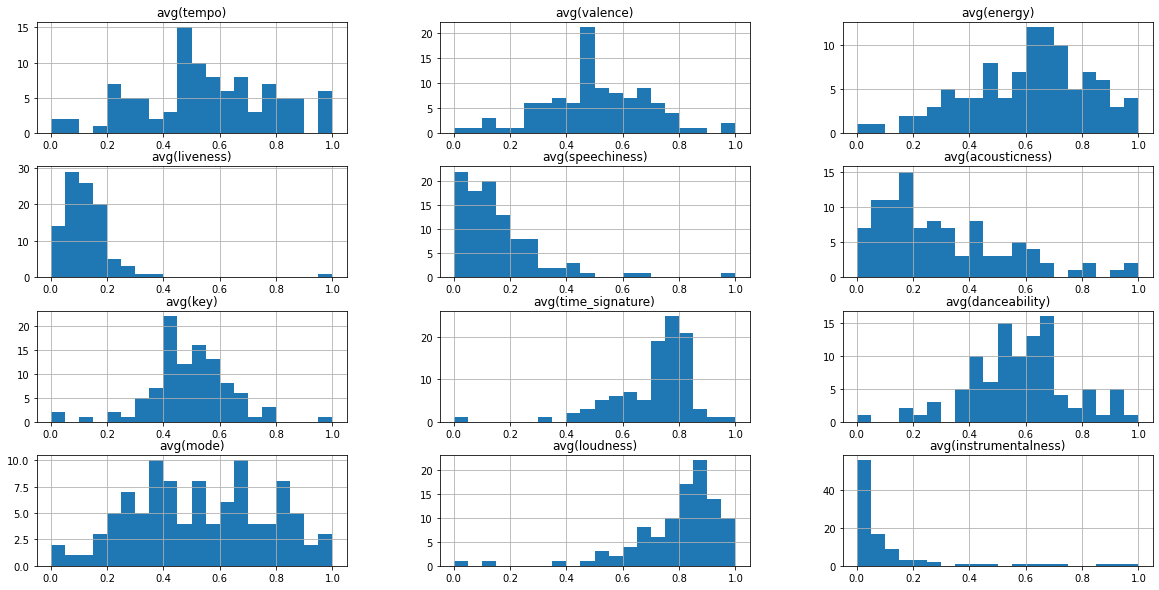

In [55]:
# Create Visualization for each feature type

fig, axes = plt.subplots(len(playlist_features_aggregate.columns)//3, 3, figsize=(20, 10))

i = 0
for triaxis in axes:
    for axis in triaxis:
        playlist_features_aggregate.hist(column = playlist_features_aggregate.columns[i], bins = 20, ax=axis)
        i = i+1

### 3.4.2.1 Popularity Track Vector

In [56]:
# Create df for all popularity data that have no nulls, set index for track_uri
playlist_popularity_no_nulls = playlist_features_by_track.dropna(axis=0,subset=['popularity'])
master_track_popularity_data = playlist_popularity_no_nulls[['track_uri','popularity']]
master_track_popularity_data = master_track_popularity_data.set_index('track_uri')

In [57]:
# Master Popularity data for Tracks (3/6)
master_track_popularity_data

,popularity
track_uri,
3kdMzXOcrDIdSWLdONHNK5,0.724138
7aOor99o8NNLZYElOXlBG1,0.781609
45HAjqRWiNv6mMPw4NvZrU,0.678161
5y1jgbDNgTfxoWXv3FhH2Q,0.632184
2UZtI2HUyLRzqBjodvcUmY,0.758621
...,...
76ictxnZf8a4MAmaeNqvbU,0.333333
0MHJ3Obkdl3EN29A8nv6uz,0.436782
4POJUFV0qevJyeAX0j2mxR,0.482759


### 3.4.2.2 Popularity Playlist Vector

In [58]:
# Create second Spark df for popularity dataset
spark_df2 = spark.createDataFrame(playlist_popularity_no_nulls) 

In [59]:
# Group our popularity data by playlist
playlist_popularity_aggregate_spark = spark_df2.groupBy('playlist_id').agg({'popularity':'mean'})

In [60]:
# Send our spark df to Pandas and set index to playlist id (4/6)
playlist_popularity_aggregate = playlist_popularity_aggregate_spark.toPandas()
playlist_popularity_aggregate = playlist_popularity_aggregate.set_index('playlist_id')
playlist_popularity_aggregate

,avg(popularity)
playlist_id,
161637,0.326230
102585,0.634261
108597,0.466595
108807,0.445680
154640,0.218391
...,...
184707,0.431965
101224,0.518953
182403,0.678161


### 3.4.3.1 Genre Track Vector

In [61]:
# Prepare dataframe for genre for tracks

playlist_features_by_track[playlist_features_by_track['genre_1'].notna()]

,playlist_id,track_uri,track_name,artist_name,artist_uri,album_name,danceability,energy,key,loudness,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id,genre_1,popularity
0,180831,527IbJxFcjjTix0ONdxDdS,Hearts as Strong as Horses,Applebloom,7ggsXdK95oJBkuZu1txVjC,Songs of Ponyville (Music from the Original TV...,0.811861,0.827313,0.090909,0.905208,...,0.033832,0.242971,0.000008,0.311861,0.908069,0.500427,0.8,7ggsXdK95oJBkuZu1txVjC,pony,NaN
2,180831,4GciJR91Tj8a7dLJ12WFvr,Ballad of the Crystal Ponies,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.646217,0.481938,0.000000,0.830322,...,0.033257,0.420682,0.000000,0.129042,0.582227,0.451542,0.8,53CQUfjaBNRwV2nFro1nac,pony,NaN
3,180831,68dC0K4xglMF5Nhr44TevS,Find a Way,Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.541922,0.391578,0.909091,0.802070,...,0.039241,0.884538,0.000000,0.094121,0.159346,0.483378,0.8,53CQUfjaBNRwV2nFro1nac,pony,NaN
4,180831,0vhKFkvwgdPBrrNr9gUbVa,"A True, True Friend",Twilight Sparkle,53CQUfjaBNRwV2nFro1nac,Songs of Ponyville (Music from the Original TV...,0.693252,0.735949,0.909091,0.862855,...,0.040852,0.306224,0.000000,0.192720,0.615935,0.483709,0.6,53CQUfjaBNRwV2nFro1nac,pony,NaN
6,180831,1XBQVELMITpvMal5Pn1UpO,Babs Seed,Applebloom,7ggsXdK95oJBkuZu1txVjC,Songs of Ponyville (Music from the Original TV...,0.829243,0.727917,0.727273,0.871030,...,0.041542,0.111444,0.000006,0.322131,0.929520,0.544519,0.8,7ggsXdK95oJBkuZu1txVjC,pony,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8068,147046,2jbupzHNwz0VgORg1uJb3D,Like A Prayer,Rufio,0HjoyITAvSVktTCjXUa40Q,Punk Goes Pop,0.315951,0.974900,0.454545,0.903563,...,0.157652,0.001434,0.000000,0.366296,0.344229,0.524618,0.8,0HjoyITAvSVktTCjXUa40Q,emo,NaN
8069,147046,6HcSRCF0R0DYRNY6vG0448,"Bye, Bye, Bye",Further Seems Forever,1Enp9WKfk0aI9CFi2YGBq7,Hope This Finds You Well (Best Of),0.441718,0.814261,0.727273,0.895436,...,0.084235,0.000154,0.000034,0.137258,0.652707,0.670022,0.8,1Enp9WKfk0aI9CFi2YGBq7,christian punk,0.367816
8071,147046,57uO0ogaSWb7t20CY85CfD,I'm Like A Bird,Element 101,6pndtpE63q5pHaGhDkoTue,Punk Goes Pop,0.544990,0.694785,0.909091,0.882205,...,0.041657,0.090561,0.000000,0.040713,0.473953,0.352306,0.8,6pndtpE63q5pHaGhDkoTue,christian punk,NaN
8073,147046,5AI3VJyLLmB8hEIoCAVClm,I'm Real,The Starting Line,3E3xrZtBU5ORqcmX78v5YZ,Punk Goes Pop,0.431493,0.887552,0.454545,0.921293,...,0.081128,0.002087,0.000000,0.386837,0.580184,0.420020,0.8,3E3xrZtBU5ORqcmX78v5YZ,emo,NaN


In [62]:
# Select genre data and set index to track_uri
genre_data_no_nulls = playlist_features_by_track[playlist_features_by_track['genre_1'].notna()].set_index('track_uri')

# OneHotEncode our data so it can be read by our model
ohe = OneHotEncoder()
X = ohe.fit_transform(genre_data_no_nulls['genre_1'].values.reshape(-1,1)).toarray()
y = ohe.get_feature_names(['genre_1'])
master_track_genre_data = pd.DataFrame(X, columns = y) 
master_track_genre_data.index = genre_data_no_nulls.index

# Final master genre data by track (5/6)
master_track_genre_data['genre_1_a cappella'].value_counts()

0.0    6120
1.0      15
Name: genre_1_a cappella, dtype: int64

### 3.4.3.2 Genre Playlist Vector

In [63]:
# Prep our track genre data
playlist_genre_prep = master_track_genre_data.join(genre_data_no_nulls['playlist_id'])

In [64]:
# Create our third spark dataframe
spark_df3 = spark.createDataFrame(playlist_genre_prep) 

In [65]:
# Aggregate our genre data by sum

genre_keys = playlist_genre_prep.columns.to_list()
genre_values = ['sum'] * 500
aggregate = dict(zip(genre_keys,genre_values))

playlist_genre_aggregate_spark = spark_df3.groupBy('playlist_id').agg(aggregate)

In [66]:
# MinMax scale our sums to weight our most common genres on a scale from 0-1
playlist_genre_aggregate = playlist_genre_aggregate_spark.toPandas()
playlist_genre_aggregate = playlist_genre_aggregate.set_index('playlist_id')
playlist_pie_chart = playlist_genre_aggregate.copy()
minmax_columns2 = playlist_genre_aggregate.columns.tolist()
playlist_genre_aggregate[minmax_columns2] = scaler.fit_transform(playlist_genre_aggregate[minmax_columns2])

# Final Master playlist data for genre (6/6)
playlist_genre_aggregate.index.get_loc(102585)

1

In [67]:
playlist_genre_aggregate.iloc[1:2]

,sum(genre_1_la pop),sum(genre_1_lovers rock),sum(genre_1_lo-fi beats),sum(genre_1_french shoegaze),sum(genre_1_neo classical metal),sum(genre_1_chicago bop),sum(genre_1_japanese indie rock),sum(genre_1_screamo),sum(genre_1_deep groove house),sum(genre_1_pop folk),...,sum(genre_1_australian alternative pop),sum(genre_1_italian metalcore),sum(genre_1_kizomba),sum(genre_1_american modern classical),sum(genre_1_christian hip hop),sum(genre_1_comic),sum(genre_1_grunge),sum(genre_1_british blues),sum(genre_1_drift),sum(genre_1_bow pop)
playlist_id,,,,,,,,,,,,,,,,,,,,,
102585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# End Spark Session
SparkSession.stop(spark)

## 3.5 Final Vectors

### Track Vector

In [69]:
# Send master track vectors to SQL

master_track_audio_features.to_sql('master_track_audio_features', con = conn, if_exists='replace')
master_track_popularity_data.to_sql('master_track_popularity_data', con = conn, if_exists='replace')
master_track_genre_data.to_sql('master_track_genre_data', con = conn, if_exists='replace')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [70]:
# Join track vectors using SQL

final_track_join = """SELECT *
                    FROM master_track_audio_features as taf
                    LEFT JOIN master_track_popularity_data as mtp
                        ON taf.track_uri = mtp.track_uri
                    LEFT JOIN master_track_genre_data as mtg
                        ON taf.track_uri = mtg.track_uri"""
# Read into Pandas and set index, impute values for most frequent
final_track_vector = pd.read_sql(final_track_join, con = conn)
final_track_vector = final_track_vector.set_index('track_uri')
impute = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
final_track_vector[final_track_vector.columns.to_list()] = impute.fit_transform(final_track_vector)

# Fix index (formatting was strange)
new_index = []

for item in range(0,len(final_track_vector.index)):
    new_index.append(final_track_vector.index[item][0])
    
final_track_vector['track_uri_fix'] = new_index
final_track_vector = final_track_vector.set_index('track_uri_fix')
final_track_vector.index = final_track_vector.index.rename(name = 'track_uri')

# Final track vector ready for modelling shape is (8081 x 513)
final_track_vector

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,genre_1_underground hip hop,genre_1_underground rap,genre_1_vancouver indie,genre_1_vapor pop,genre_1_vapor soul,genre_1_vapor twitch,genre_1_vbs,genre_1_viral pop,genre_1_viral trap,genre_1_yacht rock
track_uri,,,,,,,,,,,,,,,,,,,,,
527IbJxFcjjTix0ONdxDdS,0.811861,0.827313,0.090909,0.905208,1.0,0.033832,0.242971,0.000008,0.311861,0.908069,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1mOnMHXxt2vGI0b804eQsy,0.820041,0.815265,0.000000,0.951044,1.0,0.032911,0.232930,0.000000,0.164989,0.983657,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4GciJR91Tj8a7dLJ12WFvr,0.646217,0.481938,0.000000,0.830322,1.0,0.033257,0.420682,0.000000,0.129042,0.582227,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
68dC0K4xglMF5Nhr44TevS,0.541922,0.391578,0.909091,0.802070,1.0,0.039241,0.884538,0.000000,0.094121,0.159346,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0vhKFkvwgdPBrrNr9gUbVa,0.693252,0.735949,0.909091,0.862855,1.0,0.040852,0.306224,0.000000,0.192720,0.615935,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3G0PWfSGIsUrI4El8u46EX,0.368098,0.910644,0.000000,0.911956,1.0,0.067549,0.017769,0.000000,0.081591,0.567926,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5qpQhP4hyjCKC95oRtTqni,0.561350,0.902612,0.363636,0.882834,1.0,0.053970,0.014055,0.000676,0.134177,0.537283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7wwXG5FOebfhVBotX4vTXo,0.267894,0.943776,0.545455,0.920809,1.0,0.059839,0.000006,0.056998,0.087753,0.589377,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Playlist Vector

In [71]:
# Send playlist vectors to SQL 
playlist_features_aggregate.to_sql('playlist_features_aggregate', con = conn, if_exists='replace')
playlist_popularity_aggregate.to_sql('playlist_popularity_aggregate', con = conn, if_exists='replace')
playlist_genre_aggregate.to_sql('playlist_genre_aggregate', con = conn, if_exists='replace')

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/pandas/core/generic.py:2615: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  method=method,


In [72]:
# Join playlist vectors using SQL
final_playlist_join = """SELECT *
                    FROM playlist_features_aggregate as pfa
                    LEFT JOIN playlist_popularity_aggregate as ppa
                        ON pfa.playlist_id = ppa.playlist_id
                    LEFT JOIN playlist_genre_aggregate as pga
                        ON pfa.playlist_id = pga.playlist_id"""

# Bring vector into pandas and set index/reformat
final_playlist_vector = pd.read_sql(final_playlist_join, con = conn)
final_playlist_vector = final_playlist_vector.T.groupby(level=0).first().T
final_playlist_vector = final_playlist_vector.set_index('playlist_id')
final_playlist_vector.index = final_playlist_vector.index.astype('int')

# Impute missing values by mean
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
final_playlist_vector[final_playlist_vector.columns.to_list()] = impute.fit_transform(final_playlist_vector)
final_playlist_vector.columns = final_playlist_vector.columns.str[4:-1]

# Final playlist vector ready for modelling shape is (100 x 513)
final_playlist_vector

,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,...,genre_1_underground hip hop,genre_1_underground rap,genre_1_vancouver indie,genre_1_vapor pop,genre_1_vapor soul,genre_1_vapor twitch,genre_1_vbs,genre_1_viral pop,genre_1_viral trap,genre_1_yacht rock
playlist_id,,,,,,,,,,,,,,,,,,,,,
161637,0.148188,0.445153,0.709771,0.018887,0.552636,0.157685,0.866730,0.654421,0.326230,0.107528,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
102585,0.114856,0.546310,0.865645,0.028130,0.248950,0.120445,0.937042,0.419442,0.634261,0.216264,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108597,0.201619,0.272096,0.579360,0.000185,0.507042,0.200743,0.847355,0.865557,0.466595,0.014312,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108807,0.412638,0.676090,0.657603,0.018128,0.485424,0.060408,0.785301,0.517483,0.445680,0.127342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
154640,0.334549,0.492089,0.565782,0.021793,0.443580,0.200535,0.776752,0.783550,0.218391,0.092561,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184707,0.085384,0.512558,0.828643,0.083441,0.517708,0.118603,0.915296,0.652577,0.431965,0.052562,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101224,0.080236,0.617600,0.882427,0.024309,0.541906,0.174811,0.960932,0.556025,0.518953,0.137989,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
182403,0.270722,0.675093,0.634357,0.044887,0.479767,0.047950,0.748121,0.727273,0.678161,0.031668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Section 4: Modeling

### Content-Based Filtering using Cosine Similarity

Now that we have our vectors with our audio features, popularity, and genre data, I will use cosine similarity to build our recommendation system. Here is how it will work:

* Step 1: Our model will take a look at a selected playlist id and its vector to analyze the overall features of the songs within. 
* Step 2: Our model will then compare the playlist's vector to our unique track data vector (audio feaures, popularity, and genre) to generate a list of x number of songs (user-inputted) that are closely comparable to the playlist vectors, using cosine similarity. The greater the cosine similarity, the more similar the vectors are related. 
* Step 3: We will then analyze the features of the top song generated for reasonableness.


In [100]:
# Recommenders
def song_recommender(playlist_id,num_recs):
    # This function serves as the recommendation system behind our application below
    # Inputs pulled from spotify_recommendation function below:
    
    # playlist_id: spotify playlist id from top 100 popular playlists from our selection"
    # num_recs: number of recomendations desired
    
    # Remove songs from track vector that appear in the selected playlist. Merge and drop
    playlist_key = unique_track_data[['pid','track_uri']].set_index('pid').drop(playlist_id)
    new_final_track_vector_no_playlist_tracks = pd.merge(playlist_key,final_track_vector.reset_index(), on = 'track_uri',indicator=True, how='left')
    new_final_track_vector_no_playlist_tracks = new_final_track_vector_no_playlist_tracks.set_index('track_uri').drop('_merge',axis=1)
    
    
    # Create consine similarity model between unique tracks and playlist
    row_number = final_playlist_vector.index.get_loc(playlist_id)
    playlist_selection_vector = final_playlist_vector.iloc[row_number:row_number+1]
    playlist_feature_cos = pd.DataFrame(cos(new_final_track_vector_no_playlist_tracks,playlist_selection_vector))
    playlist_feature_cos.index = new_final_track_vector_no_playlist_tracks.index
    
    # Reformat and sort based on strongest cosine similarity value
    playlist_feature_cos = playlist_feature_cos.rename(columns = {0:playlist_id})
    playlist_feature_cos = playlist_feature_cos.sort_values(playlist_id,ascending=False).head(num_recs)
    
    # Use SQL to bring in track name, artist name and album name
    playlist_feature_cos.to_sql('playlist_feature_cos', con = conn, if_exists='replace')
    clean_recommendations = """SELECT *
                    FROM playlist_feature_cos as pfc
                    LEFT JOIN unique_track_data as utd
                        ON pfc.track_uri = utd.track_uri"""
    
    # Send to Pandas and reformat
    clean_recommendations_df = pd.read_sql(clean_recommendations, con = conn)
    clean_recommendations_df = clean_recommendations_df.drop(columns = ['index','artist_uri','pid'])
    clean_recommendations_df = clean_recommendations_df.iloc[:,2:]
    return clean_recommendations_df
    
def spotify_recommendation(playlist_id,num_recs):
    # This function provides us with our general interface for our user
    
    # Inputs:
    # playlist_id: spotify playlist id from top 100 popular playlists from our selection
    # num_recs: number of recomendations desired
    
    playlist_info = unwrapped_track_data[unwrapped_track_data['pid'] == playlist_id].set_index('pos').drop(columns=['pid','artist_uri','album_uri','duration_ms'],axis=1)
    playlist_info = playlist_info[['track_uri','track_name','artist_name','album_name']]
    dfi.export(playlist_info.head(10), 'Visualizations/playlistsnapshot'+str(playlist_id)+'.png')
    dfi.export(song_recommender(playlist_id,num_recs), 'Visualizations/recommendations'+str(playlist_id)+'.png')
    return print('\nThank you for inputting your playlist. Please see playlist tracks below:\n'),display(playlist_info), print('\n\nHere are ' + str(num_recs) + ' tracks that might fit this playlist:\n'), display(song_recommender(playlist_id,num_recs))


# Comparisons
def song_vs_playlist_comparison(playlist_id, track_uri):
    
    # This function gives us the sample variance between our selected track and the playlist mean 
    rnum = final_playlist_vector.index.get_loc(playlist_id)
    playlist_snapshot = final_playlist_vector.iloc[rnum:rnum+1].reset_index().drop('playlist_id',axis=1)
    track_snapshot = final_track_vector[final_track_vector.index==track_uri].reset_index().drop('track_uri',axis=1)
    
    # Manually calculated variance
    variance_df = np.power((playlist_snapshot - track_snapshot),2)
    variance_df['average variance'] = variance_df.mean(axis=1)
    return variance_df

def song_vs_playlist_visual_comparison(playlist_id, track_uri):
    
    # This function is for creating a cluster barchart that will show the score comparison between track and playlist 
    
    # Get track data formatted for bar graph
    track_snapshot_bar = final_track_vector[final_track_vector.index==track_uri].reset_index().drop('track_uri',axis=1)
    track_snapshot_bar = track_snapshot_bar.loc[:, (track_snapshot_bar != 0).any(axis=0)]
    size_track = len(track_snapshot_bar.columns)
    track_snapshot_bar_values = track_snapshot_bar.values.reshape(size_track).tolist()
    track_snapshot_bar_columns = track_snapshot_bar.columns.tolist()
    
    # Get playlist data formatted for bar graph
    rnum = final_playlist_vector.index.get_loc(playlist_id)
    playlist_snapshot_bar = final_playlist_vector.iloc[rnum:rnum+1].reset_index().drop('playlist_id',axis=1)
    playlist_snapshot_bar = playlist_snapshot_bar.loc[:, (playlist_snapshot_bar != 0).any(axis=0)]
    common_columns = [col for col in set(track_snapshot_bar.columns).intersection(playlist_snapshot_bar.columns)] # keep only common columns
    playlist_snapshot_bar = playlist_snapshot_bar[common_columns]
    size_playlist = len(playlist_snapshot_bar.columns)
    playlist_snapshot_bar_values = playlist_snapshot_bar.values.reshape(size_playlist).tolist()
    playlist_snapshot_bar_columns = playlist_snapshot_bar.columns.tolist()
    
    x = np.arange(len(track_snapshot_bar_columns))  # the label locations
    width = 0.35  # the width of the bars
    
    # Create plot for clustered bar graph
    fig, ax = plt.subplots(figsize=(30,15),facecolor='white')
    ax.bar(x - width/2, playlist_snapshot_bar_values,width, label='playlist data')
    ax.bar(x + width/2, track_snapshot_bar_values, width,label='top recommended track')
    sns.set_context('poster')
    ax.set_xlabel('Feature', fontsize=30)
    ax.set_ylabel('Feature Score', fontsize=20)
    ax.set_title('Features Comparison: Top Recommended Track vs. Playlist',fontsize=30)
    ax.set_xticklabels(playlist_snapshot_bar_columns, fontsize=20,rotation=45)
    ax.legend(fontsize=20)
    ax.set_xticks(x)
    plt.savefig('Visualizations/songvsplaylist'+str(playlist_id)+'.png', bbox_inches = 'tight')
    return plt.show()

# Genre population breakdown by playlist

def playlist_genre_breakdown(playlist_id):
    playlist_pie_chart_df = playlist_pie_chart
    row_number = playlist_pie_chart_df.index.get_loc(playlist_id)
    playlist_pie_chart_df = playlist_pie_chart_df.iloc[row_number:row_number+1]
    playlist_pie_chart_df = playlist_pie_chart_df.loc[:, (playlist_pie_chart_df != 0).any(axis=0)]
    playlist_pie_chart_df = playlist_pie_chart_df.loc[:, ~(playlist_pie_chart_df <= 2).any()]
    rows = playlist_pie_chart_df.shape[1]
    playlist_pie_chart_values = np.reshape(playlist_pie_chart_df.values.tolist(),rows)
    playlist_pie_chart_labels = playlist_pie_chart_df.columns.tolist()
    playlist_pie_chart_labels = [label.title() for label in playlist_pie_chart_labels] ; playlist_pie_chart_labels
    fig, ax = plt.subplots(figsize=(20,10),facecolor='white')
    sns.set_context('poster')
    ax.pie(playlist_pie_chart_values,labels=playlist_pie_chart_labels,autopct= (lambda x: '{:.0f}'.format(x*playlist_pie_chart_values.sum()/100)))
    ax.set_title('Playlist Genre Breakdown (>2 records)',fontsize=25)
    plt.savefig('Visualizations/PlaylistGenreBreakdown'+str(playlist_id)+'.png', bbox_inches = 'tight')
    return fig, ax

How can I review results when there aren't many metrics available for content-based filtering? First, I will review the overall features for our selected playlist and compare them to the top track selected by our recommendation system for reasonableness. Second, I will plot the feature scores against each other to visualize the magnitude of difference between the average playlist scores and the top recommended song. Lastly, I will listen to a selection of 3 songs on each playlist, and then I will listen to and analyze the tracks provided by our recommendation system to subjectively determine whether I think they could belong on the playlist. 

### Playlist #102585 Reasonableness Test

In [74]:
# Call function for recommender

spotify_recommendation(102585,5)


Thank you for inputting your playlist. Please see playlist tracks below:



,track_uri,track_name,artist_name,album_name
pos,,,,
0,67WTwafOMgegV6ABnBQxcE,Some Nights,fun.,Some Nights
1,6Ep6BzIOB9tz3P4sWqiiAB,Radioactive,Imagine Dragons,Night Visions
2,4wCmqSrbyCgxEXROQE6vtV,Somebody That I Used To Know,Gotye,Making Mirrors
3,5j9iuo3tMmQIfnEEQOOjxh,Best Day Of My Life,American Authors,"Oh, What A Life"
4,6cpk00i5TxCqSeqNi2HuIe,One More Night,Maroon 5,Overexposed Track By Track
...,...,...,...,...
137,1YGvv0iH1TEjMrp0oRPB5a,Louder Than Your Love,Andy Black,The Shadow Side
138,1DtLl0k0zMrFqcW0pquxpf,Broken Pieces,Andy Black,The Shadow Side
139,4WTesnTwFAtRtC6fhXuX31,The Void,Andy Black,The Shadow Side




Here are 5 tracks that might fit this playlist:



,track_uri,track_name,artist_name,album_name
0,5zT5cMnMKoyruPj13TQXGx,I Found,Amber Run,5AM (Deluxe)
1,4GITtbZtRCQXhWLMXrWXHt,Roots,Imagine Dragons,Roots
2,673WCjn0SxKJD4qRKczaCk,She Had The World,Panic! At The Disco,Pretty. Odd.
3,0z8yrlXSjnI29Rv30RssNI,Shots - Broiler Remix,Imagine Dragons,Smoke + Mirrors
4,2AObzKd3JYIWQqQ067Z0YI,Release,Imagine Dragons,Smoke + Mirrors


(None, None, None, None)

(<Figure size 1440x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Playlist Genre Breakdown (>2 records)'}>)

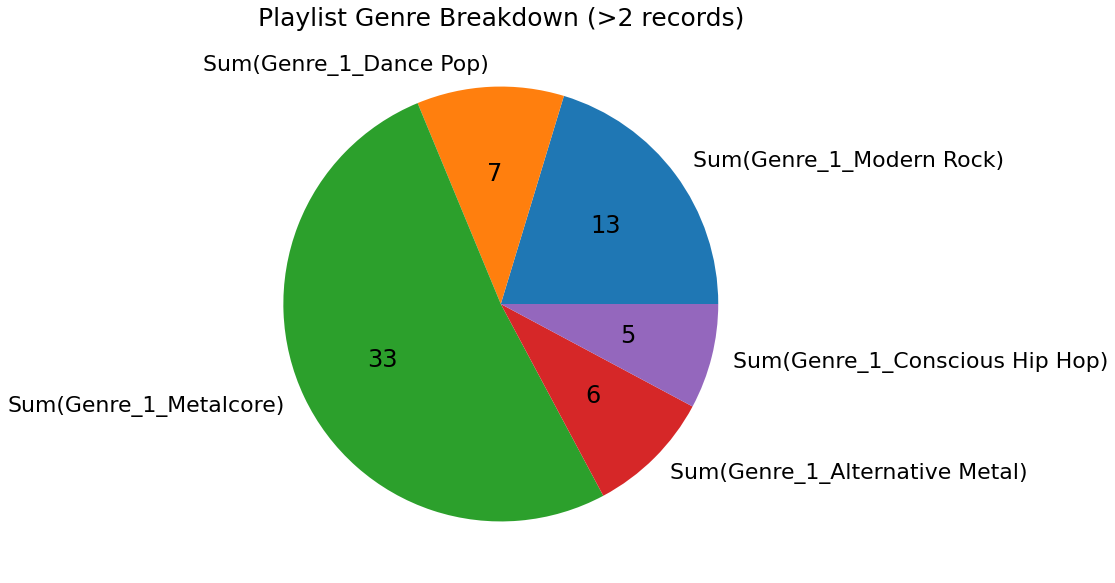

In [88]:
playlist_genre_breakdown(102585)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator


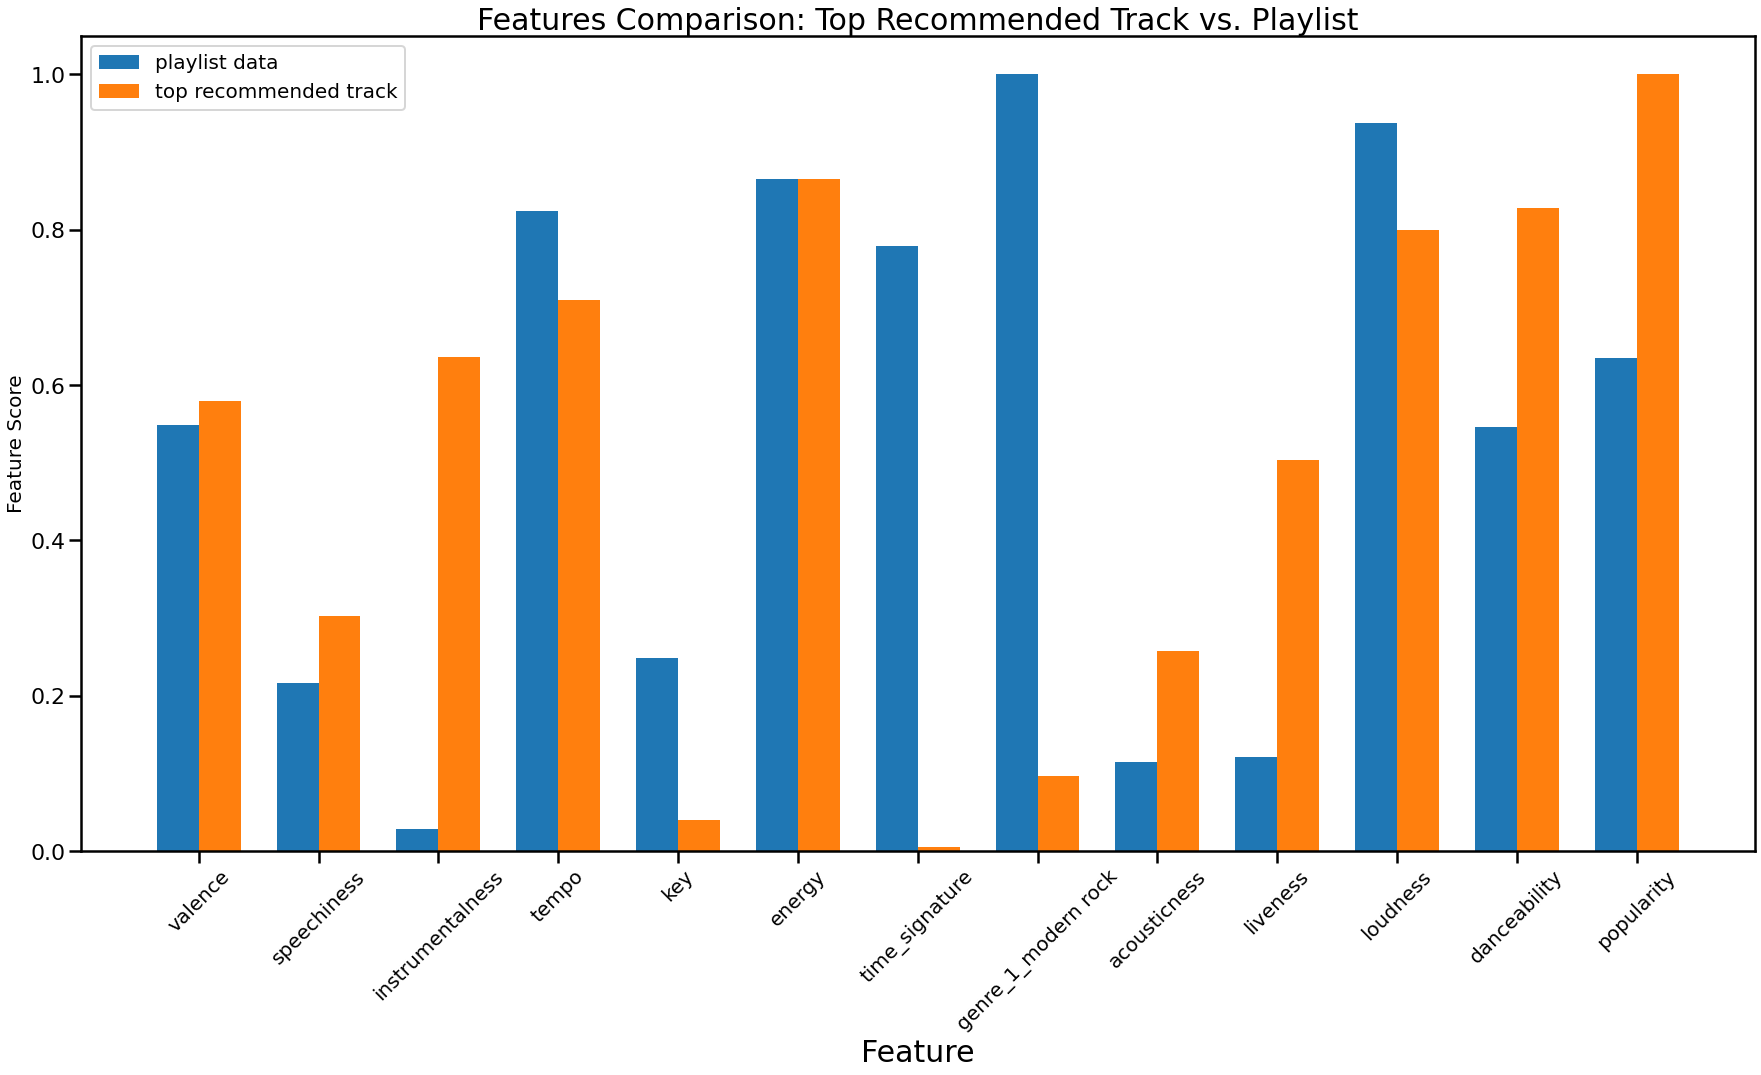

In [101]:
# Call function for graphical comparison

song_vs_playlist_visual_comparison(102585,'5zT5cMnMKoyruPj13TQXGx')

In [77]:
# Call function for variance

song_vs_playlist_comparison(102585,'5zT5cMnMKoyruPj13TQXGx')

,acousticness,danceability,energy,genre_1_21st century classical,genre_1_a cappella,genre_1_abstract beats,genre_1_abstract hip hop,genre_1_acid rock,genre_1_acoustic cover,genre_1_acoustic pop,...,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,average variance
0,0.563409,0.001119,0.317444,0.0,0.027778,0.0,0.0,0.0,0.0,0.0,...,0.150089,0.00054,0.05184,0.175932,0.037375,0.030931,0.102359,0.00043,0.084617,0.016008


As we can see above, the sample variance between our recommended song and our playlist average seems to be very low, driven mainly by the genre data. While it can be argued that our genre data is so specific that it is dominating our model, I personally think the specificity of the genre helps us narrow our recommendations down to suggest more accurate songs. 

Looking at our visualization, for the most part it appears most of the features are comparable, except for time signature, acousticness, liveness, and key. As a musician, I would argue that key and time signature does not matter too much in terms my enjoyment for music, so at first glance, I would not say that our recommendation is that far off. 

Now for the sound test. I will document my subjective findings below:

Some Nights, Radioactive, and Somebody That I Used to Know were all hits around 2013, and I personally have listened to these songs already. My description of Radioactive is an arena rock, bass thumping anthem that brings a high level of intensity. Some Nights and Somebody That I Used to Know are more chill and have a very nostaglic sound to them. 

For our recommendations, we have 3 songs by Imagine Dragons, 1 song by Panic at the Disco and our top song was Amber Run. I already know all of the songs except for the one made by Amber Run, and I would say that it is reasonable that these songs would be suggested, seeing the selection of songs on the playlist. I had to listen to the Amber Run song, and it definitely is a slower song that is lesser known to me than the others. It is definitely more acoustic and I wouldn't necessarily classify it as modern rock.

Overall, I would deem that these 5 recommended songs pass the reasonableness test.

### Playlist #765 Reasonableness Test

In [78]:
spotify_recommendation(765,10)


Thank you for inputting your playlist. Please see playlist tracks below:



,track_uri,track_name,artist_name,album_name
pos,,,,
0,03xWMkKEbeO4SnylA53ipj,"When Will My Life Begin - From ""Tangled""/Sound...",Mandy Moore,Tangled
1,1lOSxJNCLvWm2bYaTcTSmK,"Mother Knows Best - From ""Tangled""/Soundtrack ...",Donna Murphy,Tangled
2,0TCt7OFRdD8PQ6vTRQxNgQ,"I've Got a Dream - From ""Tangled""/Soundtrack V...",Mandy Moore,Tangled
3,6klpXs2uAjagnZMFkt4qkl,"I See the Light - From ""Tangled""/Soundtrack Ve...",Mandy Moore,Tangled
4,75VVIB2x1h6BfxD2PqOO57,"Healing Incantation - From ""Tangled""/Soundtrac...",Mandy Moore,Tangled
...,...,...,...,...
76,6FHUBs8P5qcjpj7C2QHdEq,Tulou Tagaloa,Olivia Foa'i,Moana
77,3ZJnc1eGicPxRitBoC7eWZ,An Innocent Warrior,Vai Mahina,Moana
78,2bwSCIuNtVrQPVddCi8sOW,Where You Are,Christopher Jackson,Moana




Here are 10 tracks that might fit this playlist:



,track_uri,track_name,artist_name,album_name
0,2stkLJ0JNcXkIRDNF3ld6c,"You've Got A Friend In Me - From ""Toy Story""/ ...",Randy Newman,Toy Story
1,7G061Oqw7NXFr1NDTpXoI4,"Happy Working Song - From ""Enchanted""/Soundtra...",Amy Adams,Enchanted
2,7wjiMdiSgsL9Vkrwb10Num,On My Way,Phil Collins,Brother Bear
3,6mDxu0xwhv5tn1oMTNUypu,Something There,Robby Benson,Beauty and the Beast
4,6ZgigeSB0XUMqc0jjzaq6d,"You're A Mean One, Mr. Grinch",Thurl Ravenscroft,How The Grinch Stole Christmas
5,2dlxN435ZY9ruxGYND2Hq0,Almost There,Anika Noni Rose,The Princess and the Frog
6,2s6wCS3vDZFPY9NOTlPXJZ,Take Me Home - 2016 Remastered,Phil Collins,No Jacket Required (Remastered)
7,0jkGkwy510cvhy0jYPFme4,"Kingdom Dance - From ""Tangled""/Score",Alan Menken,Tangled
8,4qKDjmz094Bu2wMepNuwVN,Main Title / Once Upon A Dream / Prologue - Fr...,Chorus - Sleeping Beauty,Sleeping Beauty
9,0QKHM0vKGZcgRpryeqtYkG,The Chipmunk Song,Alvin & The Chipmunks,Alvin & The Chipmunks / OST


(None, None, None, None)

(<Figure size 1440x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Playlist Genre Breakdown (>2 records)'}>)

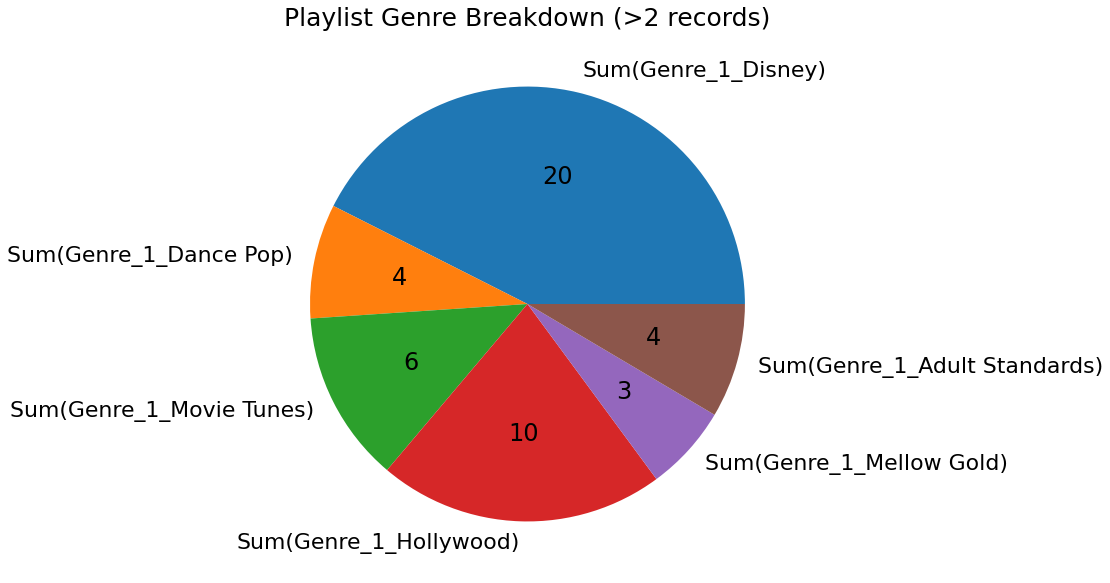

In [90]:
playlist_genre_breakdown(765)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator


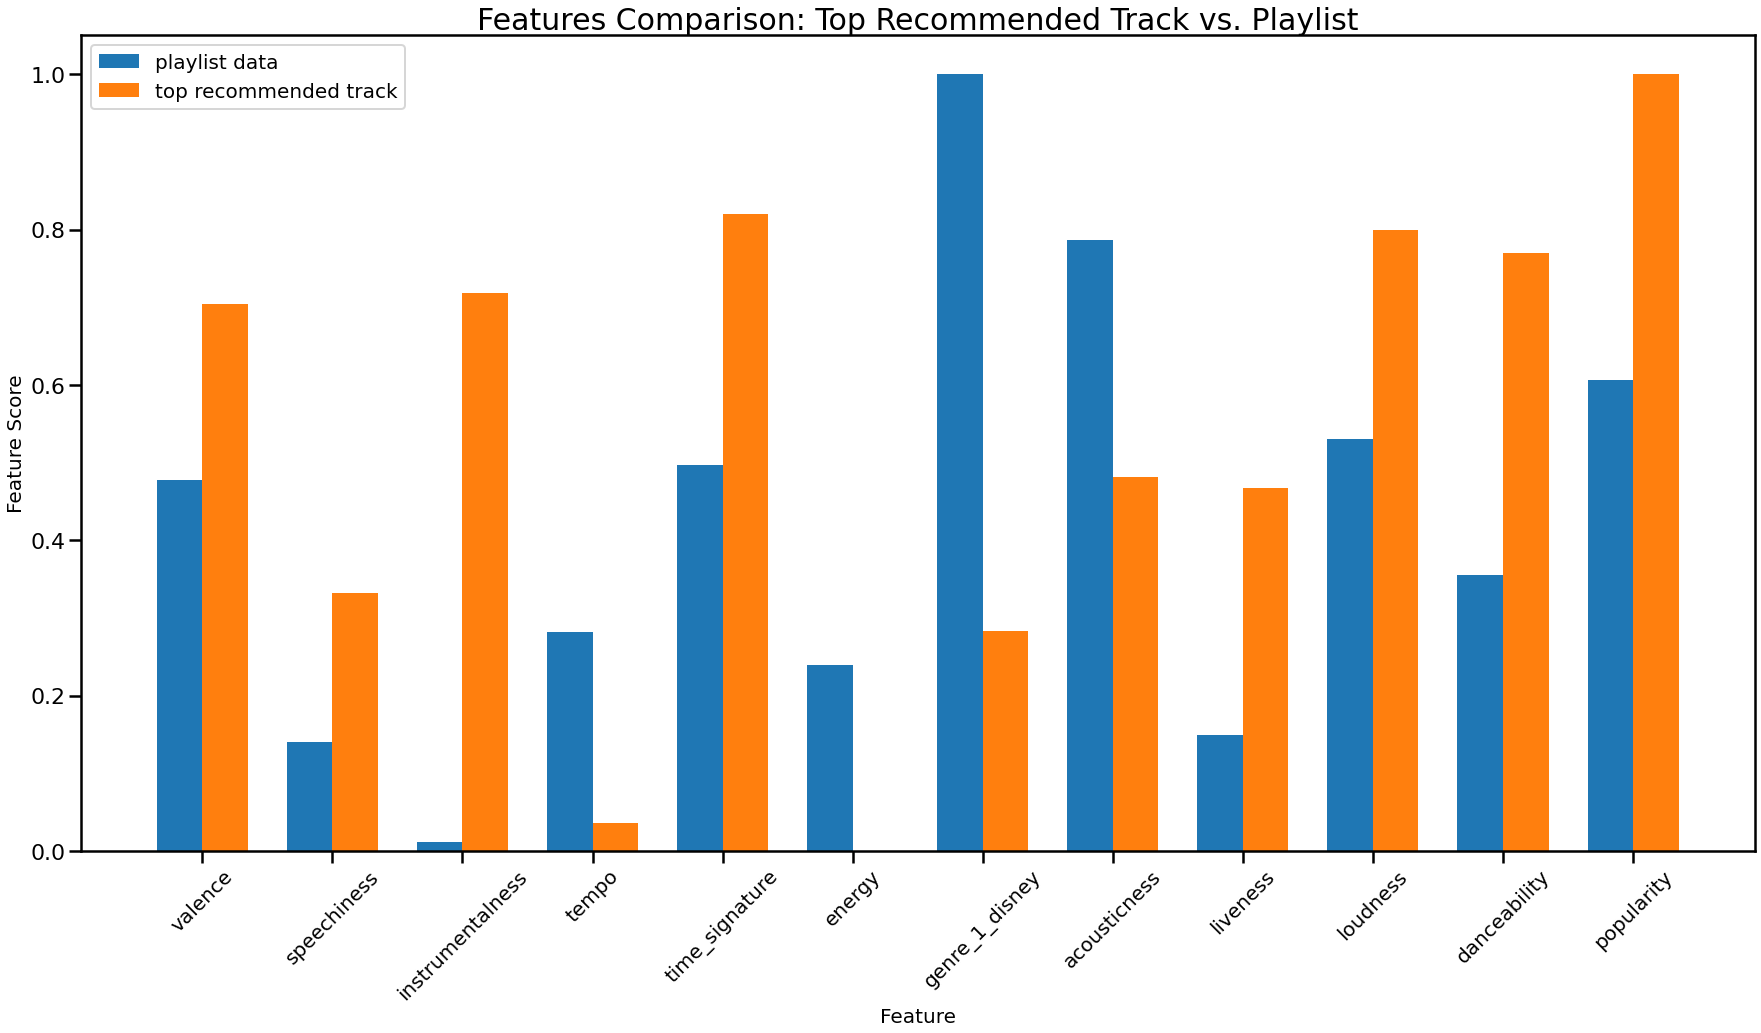

In [96]:
song_vs_playlist_visual_comparison(765,'2stkLJ0JNcXkIRDNF3ld6c')

In [81]:
song_vs_playlist_comparison(765,'2stkLJ0JNcXkIRDNF3ld6c')

,acousticness,danceability,energy,genre_1_21st century classical,genre_1_a cappella,genre_1_abstract beats,genre_1_abstract hip hop,genre_1_acid rock,genre_1_acoustic cover,genre_1_acoustic pop,...,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,average variance
0,0.001126,0.122204,0.008676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.125411,0.017874,0.03492,0.660156,0.026717,0.010956,0.034319,0.091529,0.000017,0.016046


In [82]:
unwrapped_track_data[unwrapped_track_data['pid']==765].head(50)

,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,pid
1791,0,Mandy Moore,03xWMkKEbeO4SnylA53ipj,2LJxr7Pt3JnP60eLxwbDOu,"When Will My Life Begin - From ""Tangled""/Sound...",1l0aFrH24oPrQSqGtfeFyE,152333,Tangled,765
1792,1,Donna Murphy,1lOSxJNCLvWm2bYaTcTSmK,5BuTOT6mPoNZ5EmaPheBI9,"Mother Knows Best - From ""Tangled""/Soundtrack ...",1l0aFrH24oPrQSqGtfeFyE,190440,Tangled,765
1793,2,Mandy Moore,0TCt7OFRdD8PQ6vTRQxNgQ,2LJxr7Pt3JnP60eLxwbDOu,"I've Got a Dream - From ""Tangled""/Soundtrack V...",1l0aFrH24oPrQSqGtfeFyE,191413,Tangled,765
1794,3,Mandy Moore,6klpXs2uAjagnZMFkt4qkl,2LJxr7Pt3JnP60eLxwbDOu,"I See the Light - From ""Tangled""/Soundtrack Ve...",1l0aFrH24oPrQSqGtfeFyE,224240,Tangled,765
1795,4,Mandy Moore,75VVIB2x1h6BfxD2PqOO57,2LJxr7Pt3JnP60eLxwbDOu,"Healing Incantation - From ""Tangled""/Soundtrac...",1l0aFrH24oPrQSqGtfeFyE,54440,Tangled,765
1796,5,Phil Collins,0loKEMa9DP6mLibdFMe6Uv,4lxfqrEsLX6N1N4OCSkILp,You'll Be In My Heart,6fBzYwBKjuO4hmhcGuklJM,96546,Tarzan Original Soundtrack,765
1797,6,Donny Osmond,28UMEtwyUUy5u0UWOVHwiI,5ZEAzHE2TzAwUcOj6jMIgf,"I'll Make a Man Out of You - From ""Mulan""/Soun...",3Ohs7Jo6GM6mydUOL0m5aC,201680,Mulan,765
1798,7,Roger Bart,2rm72l5pjfby1cWvPMUojI,4sZw3BLoQ9SniX4mcoh80b,"Go the Distance - From ""Hercules""/Soundtrack",7z46fPkl9344yv05HT1Uoq,194160,Hercules,765
1799,8,Tony Jay,7jZcWttgE7HF35YeB9dzq8,5qQpn0ZokyamZjyKtkKUYD,The Bells Of Notre Dame,4oO2rv8QInfX4jVrCdLzlp,386426,The Hunchback of Notre Dame Original Soundtrack,765
1800,9,Judy Kuhn,1OYOLWqKmhkFIx2KC9ek1a,7tHd518aPjJYUgyv9bidBz,Colors Of The Wind,7L6kEZVkWh7OEI71b1JHZd,214400,Pocahontas,765


As we can see above, the sample variance between our recommended song and our playlist average is very low, driven mainly by the genre data.

Looking at our visualization, for the most part it appears most of the features are comparable, except for the instrumentalness and energy. Seeing that the general theme of this playlist seems to be soundtrack for childrens movies, again, I believe that genre is the most important driver of the recommender here. Our most common genre, disney, seems a little off, but that can be explained because not all childrens movies are necessarily Disney movies.

Now for the sound test. I will document my subjective findings below:

As we can see from our selection of songs, they all seem to be Disney songs from Moana and Tangled. I would expect that our recommendation system would suggest other kids songs accross childrens movies. After pulling more songs from the unwrapped track data, I can confirm that there are some songs that are not Disney.

For our recommendations, all 10 songs appear to be soundtrack songs, which is great, and they are all mainly from beloved kids movies. Because it seems like kids movie is the main category for this playlist, I will not review the other audio features.

Overall, I would deem that these 10 recommended songs pass the reasonableness test.

### Playlist #160101 Reasonableness Test

In [83]:
spotify_recommendation(160101,5)


Thank you for inputting your playlist. Please see playlist tracks below:



,track_uri,track_name,artist_name,album_name
pos,,,,
0,4w3dm0pGQ9otu7cG5uWy88,Not Just a Girl,She Wants Revenge,Valleyheart
1,37r6i0GTqgR05rGe5wNhmp,"When They Fight, They Fight",Generationals,Con Law
2,0grFc6klR3hxoHLcgCYsF4,Howlin' For You,The Black Keys,Brothers
3,6M23RkYPbVR91c4iWVNkcl,Changing,The Airborne Toxic Event,All At Once
4,5nHRIKsXDwUpse9gzrAxLR,Oxford Comma,Vampire Weekend,Vampire Weekend
...,...,...,...,...
202,6T9ZJ2cJbtF4eDapnRHCux,Death Valley,My Jerusalem,Preachers
203,2QVmiA93GVhWNTWQctyY1K,Outro,M83,"Hurry Up, We're Dreaming"
204,7raMTVKDjLfTAyfDXKIfrz,Beneath The Surface,Demons Of Ruby Mae,Beneath The Surface




Here are 5 tracks that might fit this playlist:



,track_uri,track_name,artist_name,album_name
0,54KFQB6N4pn926IUUYZGzK,To Build A Home,The Cinematic Orchestra,Ma Fleur
1,13PUJCvdTSCT1dn70tlGdm,"Welcome Home, Son",Radical Face,Ghost
2,2gZNwCpx5Twi1fQO94AY3G,The Lakes,James Vincent McMorrow,Post Tropical
3,5dulWCZyRqio1YhzwCc4P4,King Of Spain,The Tallest Man On Earth,The Wild Hunt
4,3iTi975Q6qnoRKrBL1FNsl,Gold,Matt Hartke,Gold


(None, None, None, None)

(<Figure size 1440x720 with 1 Axes>,
 <AxesSubplot:title={'center':'Playlist Genre Breakdown (>2 records)'}>)

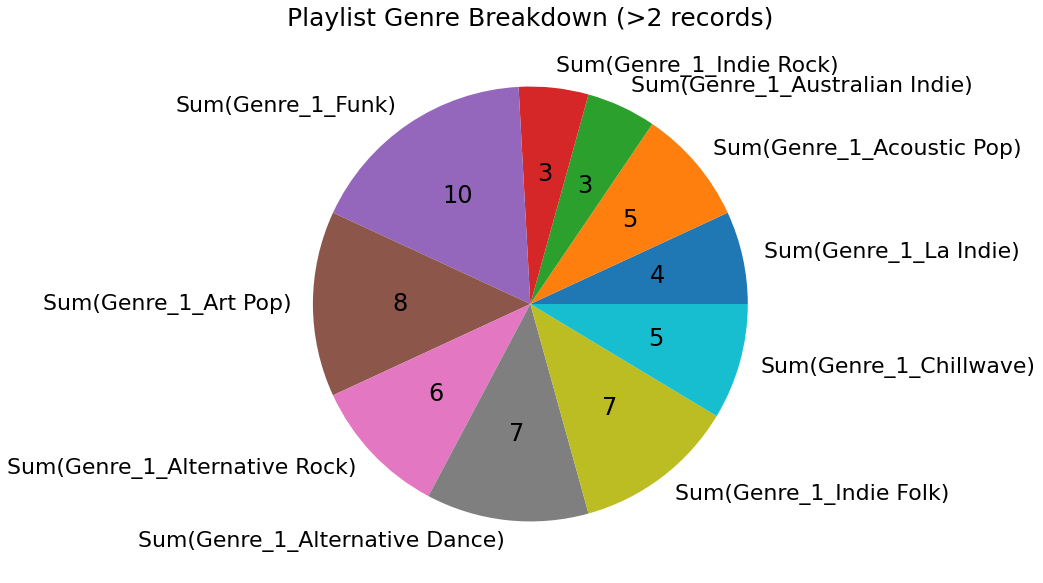

In [92]:
playlist_genre_breakdown(160101)

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator


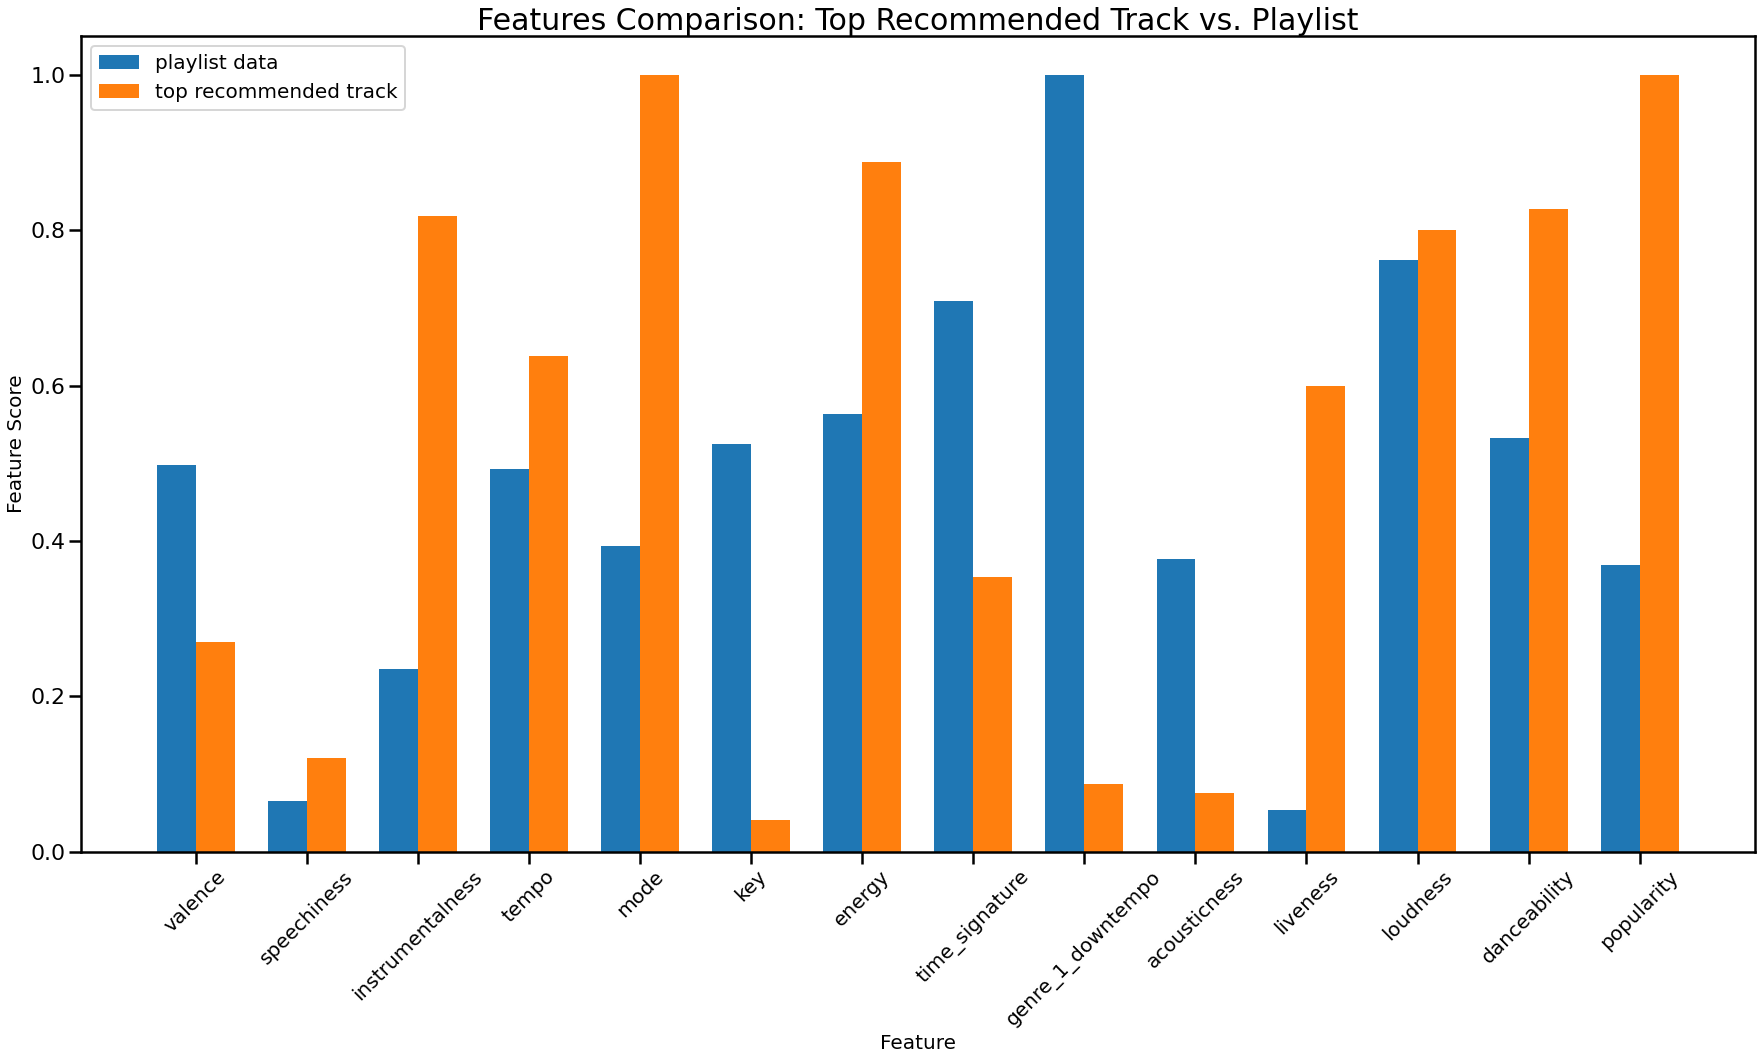

In [97]:
song_vs_playlist_visual_comparison(160101,'54KFQB6N4pn926IUUYZGzK')

In [86]:
song_vs_playlist_comparison(160101,'54KFQB6N4pn926IUUYZGzK')

,acousticness,danceability,energy,genre_1_21st century classical,genre_1_a cappella,genre_1_abstract beats,genre_1_abstract hip hop,genre_1_acid rock,genre_1_acoustic cover,genre_1_acoustic pop,...,key,liveness,loudness,mode,popularity,speechiness,tempo,time_signature,valence,average variance
0,0.261405,0.06918,0.195705,0.0,0.0,0.0,0.0,0.0,0.020408,0.694444,...,0.085887,0.001079,0.015194,0.368228,0.209732,0.0006,0.011306,0.008367,0.178234,0.081381


As we can see above, the sample variance between our recommended song and our playlist average is very low, driven mainly by the genre data.

According to our visualization, our top song features appear to be a little more variable, with most feautres having a large distance. I think this once again proves that our specific genre data is the driver for our model.

Now for the sound test. I will document my subjective findings below:

From our playlist, I already recognize M83, the Black Keys and Vampire Weekend. Outro by M83 is very spacy and slow, whereas Howlin' For You is more uptempo and rock themed. Oxford Comma is also uptempo and kind of spaced out, but overall sounds chill. Not Just a Girl is slower paced, but also sounds like alt-rock overall. For our recommendations, I would expect chiller alt-rock that is slower in pace and has mostly fleshed out instrumentals.

For our recommendations, I recognize none of the songs. To Build a Home is definitely a very slow song, and I would argue it sounds more like pop than alt-rock, but if our main genre for our playlist is "Downtempo," I would say it fits. Welcome Home, Son by Radical Face sounds like chill folk-rock, comparable to the Lumineers. Based on the type of playlist, I think this is a decent recommendation. King of Spain also sounds like folk, similar to Welcome Home, Son. The Lakes and Gold give me a similar feeling to To Build a Home, they are very slow and sound more like chill pop.

This playlist seems like there is more variety between the genres, and as such, my recommendations also seem varied. The thing in common does appear to be the style of songs being acoustic and instrumental and downtempo overall. I would say that these recommendations are adequate.

# Section 5: Results

To summarize: using cosine similarity, I was able to successfully create a recommendation system using a selection of data from the Spotify Million Playlist Dataset. Overall, I have identified 3 potential drawbacks that might affect this model: 1. Suggesting songs from the same basket that the machine is learning from may create bias, 2. There are few metrics to assess our system, which makes it harder to determine the broader success of the model, 3. I analyzed the model using subjectivity. Tastes can be very different and subjectivity begets bias, as well. With these in mind, however, I beleive that this recommendation system is adequate at suggesting similar songs based on our tests in the results section.

As shown in the results section, our music recommendations seem to be driven mainly by the genre. Extracting Genre data from Spotipy provided us with very specific genre data that might've been able to isolate our list to a very select handful of songs. It then used the audio features and popularity vectors to differentiate the songs when it came to using cosine similarity.

I believe some good improvements to this project would be to source more general genre data if it is eventually made available as an export from Spotipy. As I had to manually export the data from Spotipy usng different means, it is hard to tell how accurate the genre data actually is. I would also like to include information on the year released, in case a playlist is related to a certain year, for example, 2013s hits. I would also like user-review data that shows how much a user liked a song, so I could try a collaborative-based filtering approach. Another thing I would like to do is research other forms of content-based recommendation systems, perhaps some form of clustering. Lastly, if I had a faster computer I would include all of the playlists in my analysis to capture more songs for my recommendation system.